In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

C:\Users\eleib\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')

## NOTE FROM JAZMYN: train all of ur models with train_with_age (I imputed missing values of age)

Also, I found that since SibSp / Parch / Pclass are discrete variables I counted them as categorical and converted them to strings! This might not be the case moving forward but I found it improves the model a lot. There is probably really moderate correlation between SibSp and Parch, Pclass / Fare / Age, etc. I didn't have time to explore it in my section but y'all are welcome to

## Data Cleaning - Jazmyn

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Variable Explanations:

Survived: 0=No, 1=Yes

Pclass: 1 = first class, 2 = second class, 3 = third class

sibsp: number of siblings and spouses aboard Titanic

parch: number of parents and children aboard Titanic

ticket: ticket number

fare: passenger fare

cabin: cabin number

embarked: port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
train.shape

(891, 12)

There are only 204 observations for "Cabin", and so it's probably not worth imputing those data points. Moreover, after some preliminary research, I found that Cabins are just divided by Pclass, a variable we already have, so even if we did include it in the model, they would be correlated variables. What may be informative, however, is imputing values of Age. Let's explore that:

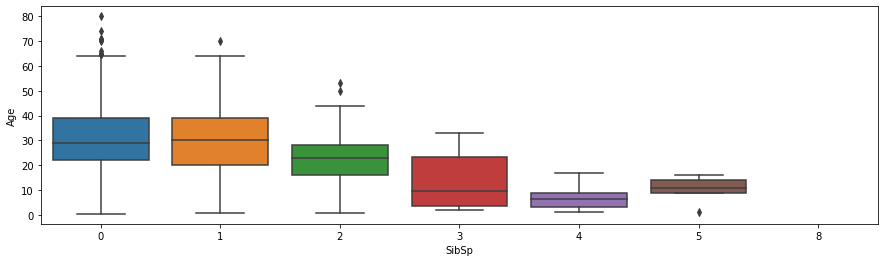

In [8]:
ax = sns.boxplot(x="SibSp", y = 'Age',  data=train)
ax.figure.set_figwidth(15)

Seems like there is a trend where increased number of siblings and spouses means smaller age

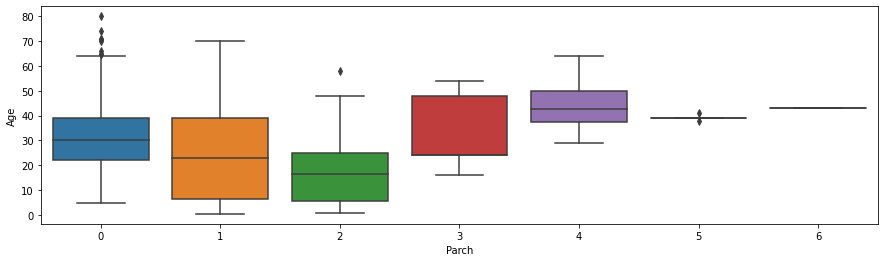

In [9]:
ax = sns.boxplot(x="Parch", y = 'Age',  data=train)
ax.figure.set_figwidth(15)

There also seems to be some correlation

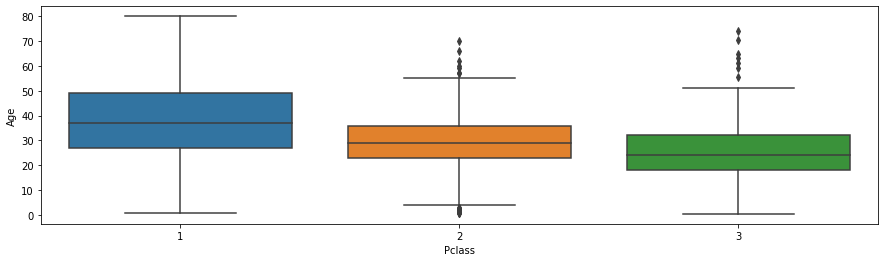

In [10]:
ax = sns.boxplot(x="Pclass", y = 'Age',  data=train)
ax.figure.set_figwidth(15)

Higher class, older people

<AxesSubplot:xlabel='Age', ylabel='Count'>

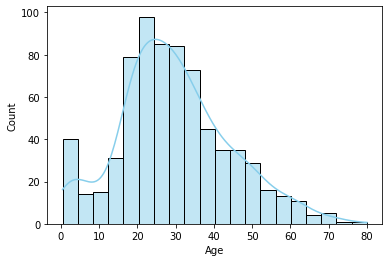

In [11]:
sns.histplot(data=train, x="Age", color="skyblue", kde=True)

Text(0, 0.5, 'Age')

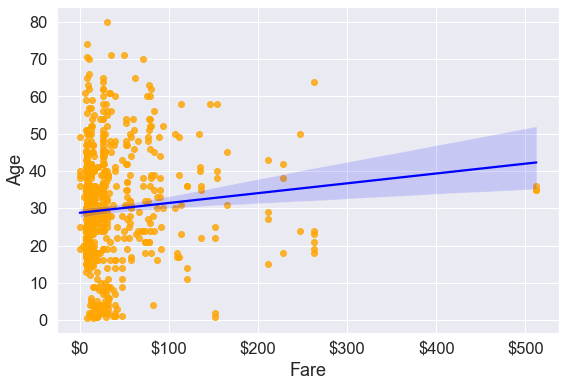

In [12]:
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.5)
ax=sns.regplot(x = 'Fare', y = 'Age', data = train,scatter_kws={"color": "orange"}, line_kws={"color": "blue"})
ax.xaxis.set_major_formatter('${x:,.0f}')
ax.set_xlabel('Fare')
ax.set_ylabel('Age')

Text(0.5, 1.0, 'Age vs Fare')

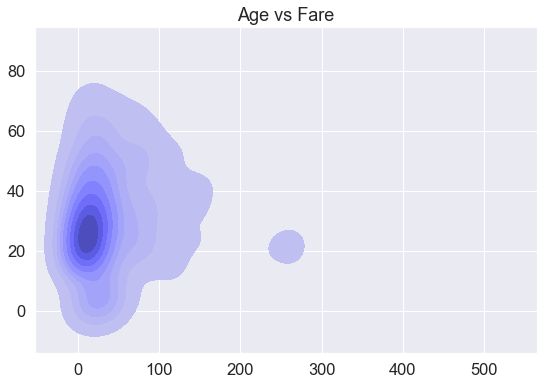

In [13]:
sns.kdeplot(train['Fare'].values, y=train['Age'].values,color='blue',shade=True )
plt.title("Age vs Fare")

PClass, Parch, and SibSp variables are categorical, not numerical. Transform to strings so model treats it as categorical

In [14]:
train['Pclass'] = train['Pclass'].apply(str)
train['Parch'] = train['Parch'].apply(str)
train['SibSp'] = train['SibSp'].apply(str)

In [15]:
missing_age = train[train['Age'].isna()] #dataframe containing only rows missing Age
has_age = train.dropna(subset=['Age']) #dataframe containing only no rows missing Age

Trying to run MLR on dataframe itself to see if we can use those values to compute Age:

In [16]:
#Using the ols function to create an ols object. 'ols' stands for 'Ordinary least squares'
ols_object = smf.ols(formula = 'Age~SibSp+Parch+Pclass', data = has_age)
model = ols_object.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     23.32
Date:                Thu, 02 Mar 2023   Prob (F-statistic):           1.04e-46
Time:                        19:31:39   Log-Likelihood:                -2794.8
No. Observations:                 714   AIC:                             5618.
Df Residuals:                     700   BIC:                             5682.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      41.5544      1.007     41.257      0.000      39.577      43.532
SibSp[T.1]     -1.8973      1.144     -1.659      0.098      -4.143       0.348
SibSp[T.2]     -6.2344      2.552     -2.443      0.015     -11.245      -1.224
SibSp[T.3]     -9.1169      3.730     -2.444      0.015     -16.439      -1.794
SibSp[T.4]    -11.6781      3.183     -3.669      0.000     -17.927      -5.429
SibSp[T.5]     -5.4223      5.781     -0.938      0.349     -16.772       5.927
Parch[T.1]     -6.2670      1.382     -4.534      0.000      -8.981      -3.553
Parch[T.2]    -12.4897      1.777     -7.029      0.000     -15.979      -9.001
Parch[T.3]      5.4890      5.555      0.988      0.323      -5.417      16.395
Parch[T.4]     14.4504      6.188      2.335      0.020       2.301      26.600
Parch[T.5]     12.2263      5.548      2.204      0.028       1.333      23.119
Parch[T.6]     16.7853     12.307      1.364      0.173      -7.377      40.948
Pclass[T.2]    -8.4817      1.298     -6.535      0.000     -11.030      -5.933
Pclass[T.3]   -13.4423      1.148    -11.713      0.000     -15.696     -11.189
==============================================================================
Omnibus:                       40.039   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.394
Skew:                           0.588   Prob(JB):                     1.39e-10
Kurtosis:                       3.376   Cond. No.                         32.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared kinda mid, let's check our model assumptions:

Text(0, 0.5, 'Residuals')

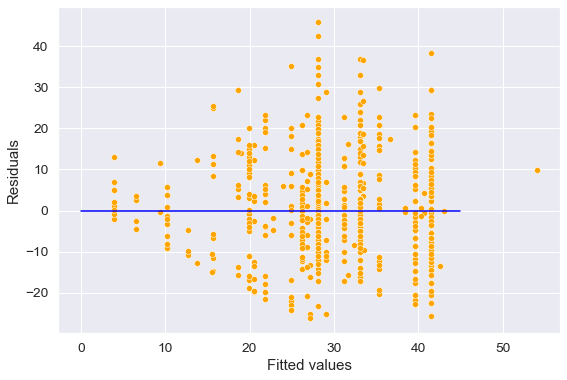

In [17]:
#Plotting residuals vs fitted values
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model.fittedvalues, y=model.resid,color = 'orange')
sns.lineplot(x = [0,45],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

Does not violate non-linearity of data, but there does seem to be non-constant variance of error terms. Take sqrt transformation of Age and see if it resolves this issue:

In [18]:
#Using the ols function to create an ols object. 'ols' stands for 'Ordinary least squares'
ols_object = smf.ols(formula = 'np.sqrt(Age)~SibSp+Parch+Pclass+Fare', data = has_age)
model_sqrt_age = ols_object.fit()
model_sqrt_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.sqrt(Age)   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     26.74
Date:                Thu, 02 Mar 2023   Prob (F-statistic):           3.89e-56
Time:                        19:31:46   Log-Likelihood:                -1141.2
No. Observations:                 714   AIC:                             2312.
Df Residuals:                     699   BIC:                             2381.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.5176      0.134     48.479      0.000       6.254       6.782
SibSp[T.1]     -0.1719      0.113     -1.522      0.128      -0.394       0.050
SibSp[T.2]     -0.7000      0.253     -2.764      0.006      -1.197      -0.203
SibSp[T.3]     -1.0391      0.371     -2.803      0.005      -1.767      -0.311
SibSp[T.4]     -1.5136      0.314     -4.816      0.000      -2.131      -0.896
SibSp[T.5]     -0.7256      0.571     -1.271      0.204      -1.847       0.395
Parch[T.1]     -0.9035      0.138     -6.556      0.000      -1.174      -0.633
Parch[T.2]     -1.4262      0.179     -7.977      0.000      -1.777      -1.075
Parch[T.3]      0.4934      0.549      0.899      0.369      -0.584       1.571
Parch[T.4]      1.2739      0.615      2.072      0.039       0.067       2.481
Parch[T.5]      1.1880      0.549      2.165      0.031       0.111       2.265
Parch[T.6]      1.5659      1.216      1.288      0.198      -0.822       3.954
Pclass[T.2]    -0.8557      0.149     -5.762      0.000      -1.147      -0.564
Pclass[T.3]    -1.3142      0.142     -9.284      0.000      -1.592      -1.036
Fare           -0.0009      0.001     -0.751      0.453      -0.003       0.001
==============================================================================
Omnibus:                        6.406   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                6.815
Skew:                          -0.162   Prob(JB):                       0.0331
Kurtosis:                       3.352   Cond. No.                     1.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared improves a bit. Let's check the residuals

Text(0, 0.5, 'Residuals')

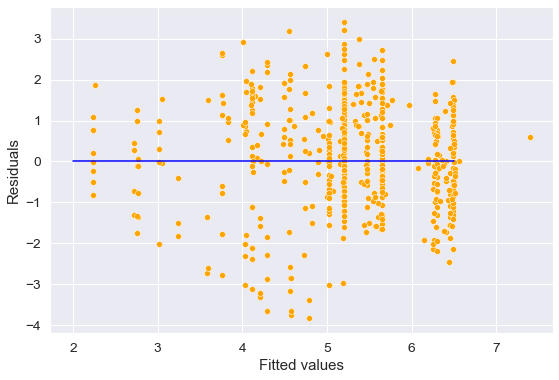

In [19]:
#Plotting residuals vs fitted values
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model_sqrt_age.fittedvalues, y=model_sqrt_age.resid,color = 'orange')
sns.lineplot(x = [2,6.5],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

Better. Not really worth doing any variable transformations since Fare isn't significant in this model anyways, and the rest of the variables are categorical. As a last step, see if we need to remove outliers, high leverage points, and influential points

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:696: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


Text(0, 0.5, 'Studentized Residuals')

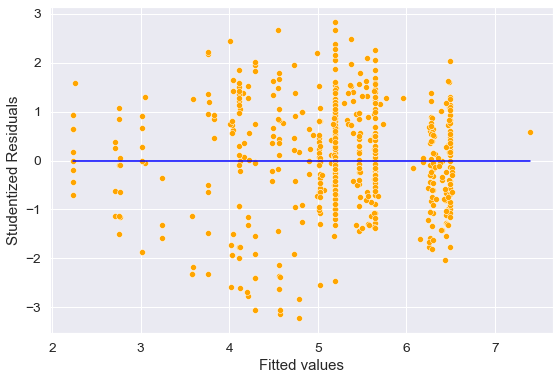

In [20]:
#Studentized residuals
out = model_sqrt_age.outlier_test()
#Plotting studentized residuals vs fitted values
sns.scatterplot(x = (model_sqrt_age.fittedvalues), y=(out.student_resid),color = 'orange')
sns.lineplot(x = [model_sqrt_age.fittedvalues.min(),model_sqrt_age.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Studentized Residuals')

Seems to be 4 outliers

In [21]:
influence = model_sqrt_age.get_influence()
leverage = influence.hat_matrix_diag
average_leverage = (model_sqrt_age.df_model+1)/model_sqrt_age.nobs
high_leverage_threshold = 3*average_leverage
np.sum(leverage>high_leverage_threshold)

37

35 high leverage points

In [22]:
#Dropping influential points from data
has_age_filtered = has_age.drop(np.intersect1d(np.where(np.abs(out.student_resid)>3)[0],
                                           (np.where(leverage>high_leverage_threshold)[0])))

In [23]:
has_age_filtered.shape

(714, 12)

No influential points!

Now we can predict age! In the missing_age dataframe, there are 7 rows where 'SibSp' = 8, but our model which includes people that have age only includes 'SibSp' from 1 to 5. Hence, the model can't fit those values. Maybe we can hand-impute them?

In [24]:
missing_age.loc[missing_age['SibSp']=='8']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


They all seem to come from the same family! Did a little bit of research, and found some information about this family: Stella (born 1891), George John (born 1892), Douglas Bullen (born 1894), Frederick (born 1895), Dorothy Florence (born 1897), Anthony William (born 1899), Elizabeth Ada (born 1901), Constance Gladys (born 1904), Thomas Henry (born 1911). Soure: https://www.nationalarchives.gov.uk/titanic/stories/sage-family.htm

Titanic sunk in 1912
Thomas: 1
Constance: 8
Fredrick: 17
George: 20
Stella: 21
Douglas: 18
Dorothy: 15

Add these values into "train" dataframe, re-make missing_age and has_age, rerun model, then do prediction!

In [25]:
train.loc[159,'Age']=1
train.loc[180,'Age']=8
train.loc[201,'Age']=17
train.loc[324,'Age']=20
train.loc[792,'Age']=21
train.loc[846,'Age']=18
train.loc[863,'Age']=15

In [26]:
missing_age = train[train['Age'].isna()] #dataframe containing only rows missing Age
has_age = train.dropna(subset=['Age']) #dataframe containing only no rows missing Age

In [27]:
ols_object = smf.ols(formula = 'np.sqrt(Age)~SibSp+Parch+Pclass+Fare', data = has_age)
model_age_final = ols_object.fit()
model_age_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.sqrt(Age)   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     25.80
Date:                Thu, 02 Mar 2023   Prob (F-statistic):           2.59e-57
Time:                        19:32:07   Log-Likelihood:                -1152.4
No. Observations:                 721   AIC:                             2337.
Df Residuals:                     705   BIC:                             2410.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.5176      0.135     48.454      0.000       6.253       6.782
SibSp[T.1]     -0.1719      0.113     -1.521      0.129      -0.394       0.050
SibSp[T.2]     -0.7000      0.253     -2.762      0.006      -1.198      -0.202
SibSp[T.3]     -1.0391      0.371     -2.802      0.005      -1.767      -0.311
SibSp[T.4]     -1.5136      0.314     -4.813      0.000      -2.131      -0.896
SibSp[T.5]     -0.7256      0.571     -1.270      0.204      -1.847       0.396
SibSp[T.8]     -0.1291      0.494     -0.261      0.794      -1.099       0.841
Parch[T.1]     -0.9035      0.138     -6.553      0.000      -1.174      -0.633
Parch[T.2]     -1.4262      0.179     -7.973      0.000      -1.777      -1.075
Parch[T.3]      0.4934      0.549      0.899      0.369      -0.584       1.571
Parch[T.4]      1.2739      0.615      2.071      0.039       0.066       2.482
Parch[T.5]      1.1880      0.549      2.164      0.031       0.110       2.266
Parch[T.6]      1.5659      1.217      1.287      0.199      -0.823       3.955
Pclass[T.2]    -0.8557      0.149     -5.759      0.000      -1.147      -0.564
Pclass[T.3]    -1.3142      0.142     -9.280      0.000      -1.592      -1.036
Fare           -0.0009      0.001     -0.750      0.453      -0.003       0.001
==============================================================================
Omnibus:                        6.916   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                7.342
Skew:                          -0.173   Prob(JB):                       0.0255
Kurtosis:                       3.353   Cond. No.                     1.71e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
missing_age['Age'] = model_age_final.predict(missing_age)**2

C:\Users\eleib\AppData\Local\Temp\ipykernel_19992\2488993999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_age['Age'] = model_age_final.predict(missing_age)**2


Predict Data!

In [29]:
train_with_age = pd.concat([has_age,missing_age])

In [30]:
train_with_age.tail(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
826,827,0,3,"Lam, Mr. Len",male,26.576738,0,0,1601,56.4958,NaN,S
828,829,1,3,"McCormack, Mr. Thomas Joseph",male,27.006610,0,0,367228,7.7500,NaN,Q
832,833,0,3,"Saad, Mr. Amin",male,27.011221,0,0,2671,7.2292,NaN,C
837,838,0,3,"Sirota, Mr. Maurice",male,27.003954,0,0,392092,8.0500,NaN,S
839,840,1,1,"Marechal, Mr. Pierre",male,42.149666,0,0,11774,29.7000,C47,C
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,39.310024,1,0,17453,89.1042,C92,C
859,860,0,3,"Razi, Mr. Raihed",male,27.011221,0,0,2629,7.2292,NaN,C
868,869,0,3,"van Melkebeke, Mr. Philemon",male,26.991118,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,27.005319,0,0,349217,7.8958,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,12.854548,1,2,W./C. 6607,23.4500,NaN,S


## Exploratory Data Analysis

<AxesSubplot:xlabel='Survived', ylabel='count'>

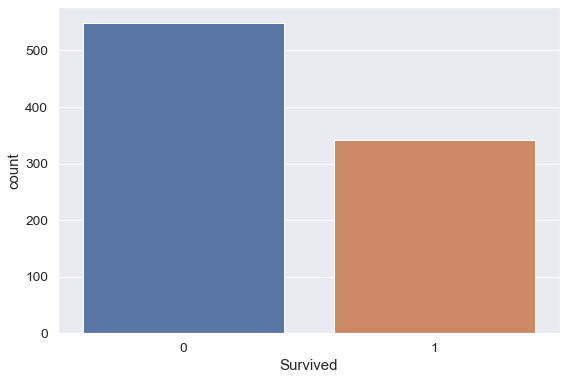

In [31]:
sns.countplot(x='Survived',data=train)

Most people died

<AxesSubplot:xlabel='Survived', ylabel='count'>

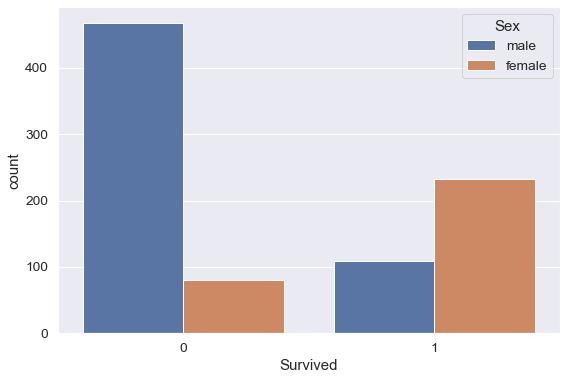

In [32]:
sns.countplot(x='Survived',data=train_with_age,hue='Sex')

more female than male survived, most people died are men

<AxesSubplot:xlabel='Survived', ylabel='count'>

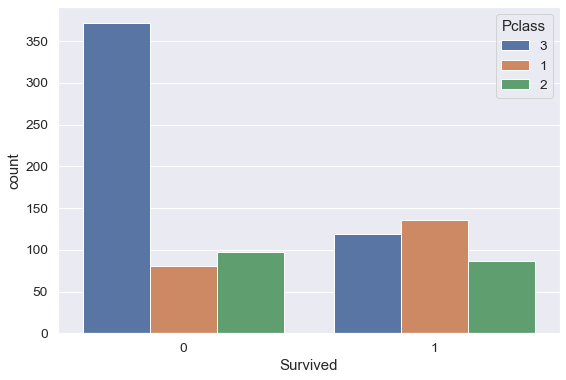

In [33]:
sns.countplot(x='Survived',data=train_with_age,hue='Pclass')

Most people that died were third class, but those that are survived pretty good mix of all

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

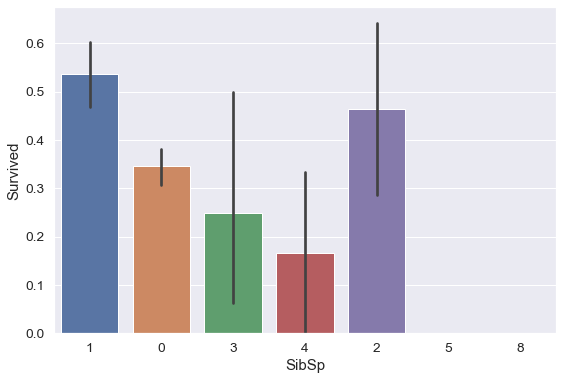

In [34]:
sns.barplot(x='SibSp',y='Survived',data=train_with_age)

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

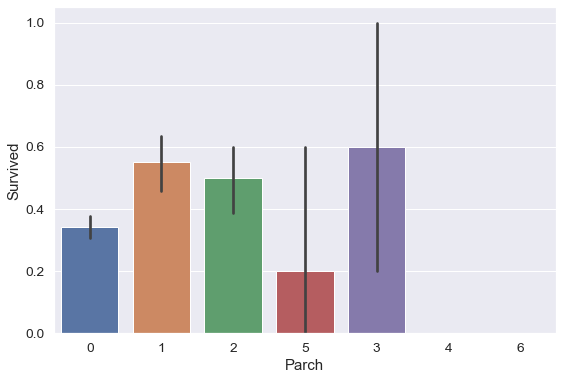

In [35]:
sns.barplot(x='Parch',y='Survived',data=train_with_age)

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

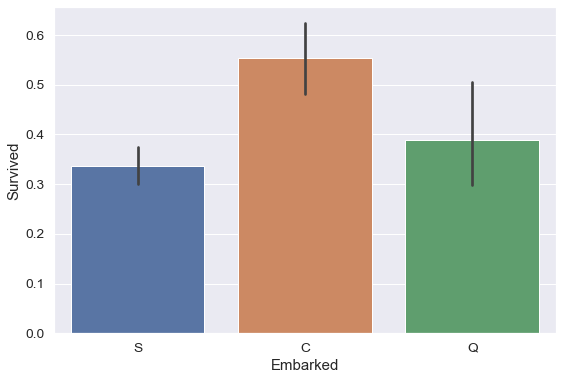

In [36]:
sns.barplot(x='Embarked',y='Survived',data=train_with_age)

In [37]:
#Binning Age
binned_age = pd.cut(train_with_age['Age'],8,retbins=True)
train_with_age['age_binned'] = binned_age[0]
age_data = train_with_age.groupby('age_binned')['Survived'].agg([('survival_percent','mean'),('nobs','count')]).reset_index(drop=False)
age_data

,age_binned,survival_percent,nobs
0,"(0.34, 10.368]",0.575758,66
1,"(10.368, 20.315]",0.373134,134
2,"(20.315, 30.263]",0.324638,345
3,"(30.263, 40.21]",0.457143,175
4,"(40.21, 50.158]",0.373832,107
5,"(50.158, 60.105]",0.404762,42
6,"(60.105, 70.052]",0.235294,17
7,"(70.052, 80.0]",0.200000,5


Text(0.5, 0, 'Age_bin')

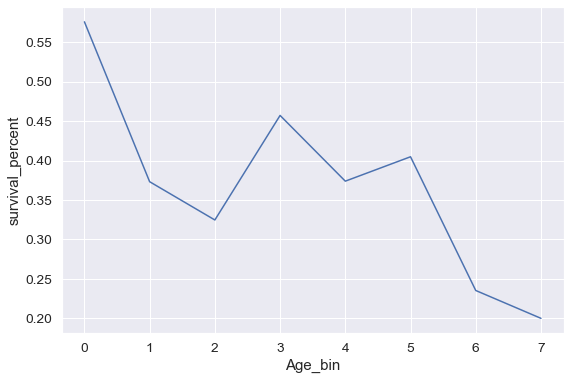

In [38]:
#Visualizing percentage of people having diabetes with increasing Age (or Age bins)
sns.lineplot(x = age_data.index, y= age_data['survival_percent'])
plt.xlabel('Age_bin')

Age is definitely a factor!

In [39]:
train_with_age.corr()

,PassengerId,Survived,Age,Fare
PassengerId,1.000000,-0.005007,0.038865,0.012658
Survived,-0.005007,1.000000,-0.048711,0.257307
Age,0.038865,-0.048711,1.000000,0.110489
Fare,0.012658,0.257307,0.110489,1.000000


<AxesSubplot:xlabel='Fare', ylabel='Count'>

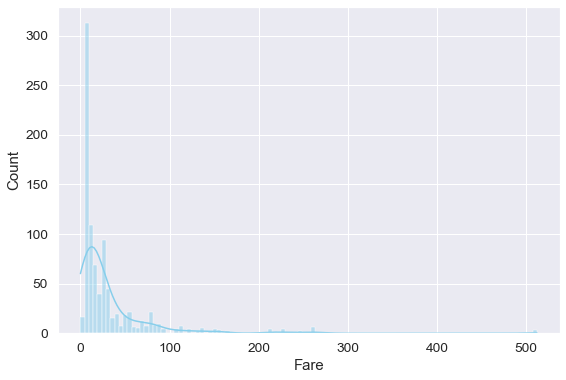

In [40]:
sns.histplot(data=train_with_age, x="Fare", color="skyblue", kde=True)

As established before, don't need Cabin column:

In [41]:
train_with_age.drop('Cabin',axis=1,inplace=True)
train_with_age.dropna(inplace=True)

## Variable Selection - David

In [42]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time

The first step in variable selection is to look at the variables that we have available to predict the survival of a given passenger. This can be seen below

In [43]:
predictors = train_with_age.columns.tolist()[2:]
X = train_with_age[predictors]

In [44]:
predictors

['Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Embarked',
 'age_binned']

The next step is to look at each variable individually, and see how preliminary regression reveals relationships between variables. In this step is was checked if each variable could form a regression, and those that errored due to lack of any correlation were dropped. 

In [45]:
to_drop = []
solo = {}
for pred in predictors:
    factor = pred
    try:
        model = sm.logit('Survived~' + factor, data = train_with_age).fit()
        #print(model.pvalues)
        solo[pred] = model
    except:
        to_drop.append(pred)
        print(pred, 'does not model')
        
print(to_drop)

Optimization terminated successfully.
         Current function value: 0.608125
         Iterations 5
Name does not model
Optimization terminated successfully.
         Current function value: 0.515526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663820
         Iterations 4
         Current function value: 0.641762
         Iterations: 35
         Current function value: 0.648598
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: inf
         Iterations: 35
Ticket does not model
Optimization terminated successfully.
         Current function value: 0.627274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.652565
         Iterations 5
['Name', 'Ticket']


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [46]:
X = X.drop(columns = to_drop)

The dropped predictors are Name and Ticket, which makes sense as the are unique to each invidual and thus there cannot be any correlation. 

In [47]:
train_with_age.dtypes

PassengerId       int64
Survived          int64
Pclass           object
Name             object
Sex              object
Age             float64
SibSp            object
Parch            object
Ticket           object
Fare            float64
Embarked         object
age_binned     category
dtype: object

Pclass params are
                     0             1
Intercept    0.515813  2.614685e-04
Pclass[T.2] -0.624616  2.240629e-03
Pclass[T.3] -1.655584  5.728842e-21
Sex params are
                     0             1
Intercept    1.047969  4.834782e-16
Sex[T.male] -2.505089  1.076430e-50
Age params are
                   0         1
Intercept -0.238328  0.150413
Age       -0.008266  0.112114
SibSp params are
                     0             1
Intercept   -0.648914  3.339052e-14
SibSp[T.1]   0.792702  1.149214e-06
SibSp[T.2]   0.505813  1.928958e-01
SibSp[T.3]  -0.449698  4.410116e-01
SibSp[T.4]  -0.960524  1.323208e-01
SibSp[T.5] -21.425465  9.993849e-01
SibSp[T.8] -18.420556  9.971887e-01
Parch params are
                     0             1
Intercept   -0.655657  6.207840e-16
Parch[T.1]   0.859752  2.091348e-05
Parch[T.2]   0.655657  5.842185e-03
Parch[T.3]   1.061122  2.469289e-01
Parch[T.4] -37.658822  9.999997e-01
Parch[T.5]  -0.730638  5.145366e-01
Parch[T.6]  -9.769780  9.575623

C:\Users\eleib\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\eleib\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


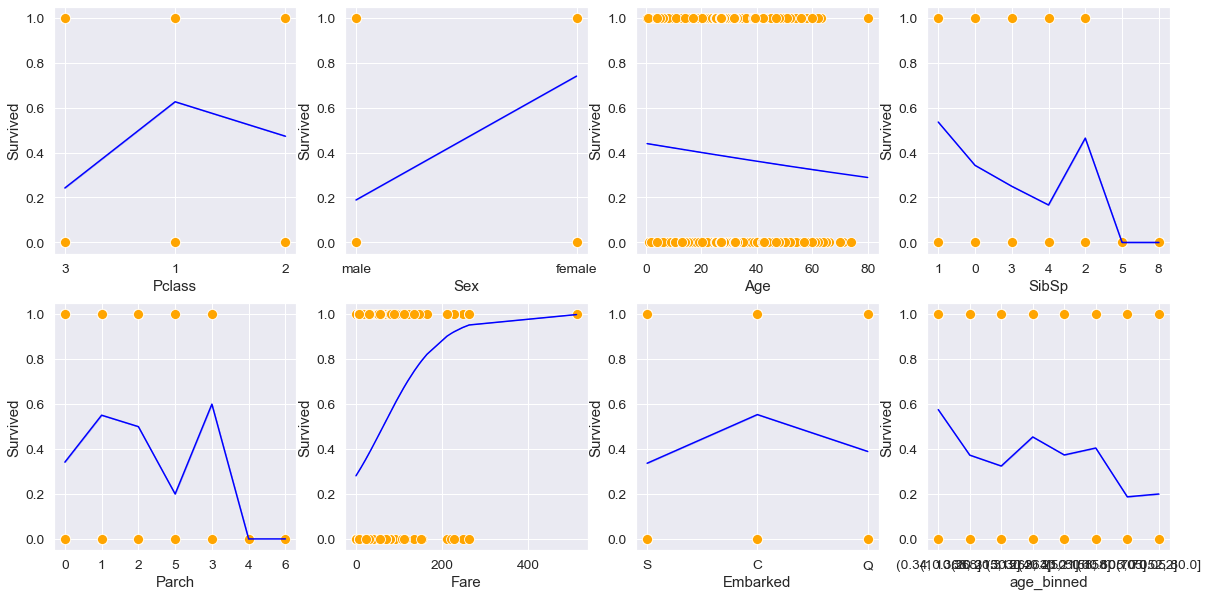

In [48]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

for i in range(len(list(solo.keys()))):
    print(solo[list(solo.keys())[i]])
    plt.subplot(2, 4, i+1)
    if list(solo.keys())[i] == 'age_binned':
        sns.scatterplot(train_with_age[list(solo.keys())[i]].apply(lambda x: str(x)), train_with_age['Survived'], color = 'orange') #Visualizing data
        logit_model = solo[list(solo.keys())[i]]
        print(list(solo.keys())[i], 'params are\n', pd.concat([solo[list(solo.keys())[i]].params, solo[list(solo.keys())[i]].pvalues], axis = 1))
        sns.lineplot(train_with_age[list(solo.keys())[i]].apply(lambda x: str(x)), logit_model.predict(train_with_age), color = 'blue') #Visualizing model
    else: 
        sns.scatterplot(x = list(solo.keys())[i], y = 'Survived', data = train_with_age, color = 'orange') #Visualizing data
        logit_model = solo[list(solo.keys())[i]]
        print(list(solo.keys())[i], 'params are\n', pd.concat([solo[list(solo.keys())[i]].params, solo[list(solo.keys())[i]].pvalues], axis = 1))
        sns.lineplot(x = list(solo.keys())[i], y = logit_model.predict(train_with_age), data = train_with_age, color = 'blue') #Visualizing model
    

This significance data and plots show interesting information to keep in mind when designing the model, such as that age does not have significant correlation (p values above 0.5, low slope) but binned age does some of the bins, and the plot is more revealing. 

In [49]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,age_binned
0,3,male,22.000000,1,0,7.2500,S,"(20.315, 30.263]"
1,1,female,38.000000,1,0,71.2833,C,"(30.263, 40.21]"
2,3,female,26.000000,0,0,7.9250,S,"(20.315, 30.263]"
3,1,female,35.000000,1,0,53.1000,S,"(30.263, 40.21]"
4,3,male,35.000000,0,0,8.0500,S,"(30.263, 40.21]"
...,...,...,...,...,...,...,...,...
849,1,female,39.310024,1,0,89.1042,C,"(30.263, 40.21]"
859,3,male,27.011221,0,0,7.2292,C,"(20.315, 30.263]"
868,3,male,26.991118,0,0,9.5000,S,"(20.315, 30.263]"
878,3,male,27.005319,0,0,7.8958,S,"(20.315, 30.263]"


In [50]:
for attr in dir(model):
    if not attr.startswith('_'):
        print(attr)

aic
bic
bse
conf_int
cov_kwds
cov_params
cov_type
df_model
df_resid
f_test
fittedvalues
get_margeff
initialize
k_constant
llf
llnull
llr
llr_pvalue
load
mle_retvals
mle_settings
model
nobs
normalized_cov_params
params
pred_table
predict
prsquared
pvalues
remove_data
resid_dev
resid_generalized
resid_pearson
resid_response
save
scale
set_null_options
summary
summary2
t_test
t_test_pairwise
tvalues
use_t
wald_test
wald_test_terms


In [51]:
model_breakers = []

def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    print('Survived~' + '+'.join(predictor_subset))
    model = sm.logit('Survived~' + '+'.join(predictor_subset),data = train_with_age).fit()
    pval = model.prsquared
    return {"model":model, "llr_pvalue":pval, "vars":predictor_subset}

def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        print(list(combo))
        try:
            results.append(processSubset((list(combo))))
        except:
            model_breakers.append(list(combo))
            print('this combo broke the model')

    print(results)
        
    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)
    print(models)

    # Choose the model with the highest RSS
    best_model = models.loc[models['llr_pvalue'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return k, models

#Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
models_best = pd.DataFrame(columns=['num_elements', "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    print(i)
    try:
        print('\n\n\n', getBest_model(i))
        models_best.loc[i] = getBest_model(i)
        print(models_best)
    except:
        print('error')

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

1
['Pclass']
Survived~Pclass
Optimization terminated successfully.
         Current function value: 0.608125
         Iterations 5
['Sex']
Survived~Sex
Optimization terminated successfully.
         Current function value: 0.515526
         Iterations 5
['Age']
Survived~Age
Optimization terminated successfully.
         Current function value: 0.663820
         Iterations 4
['SibSp']
Survived~SibSp
         Current function value: 0.641762
         Iterations: 35
['Parch']
Survived~Parch
         Current function value: 0.648598
         Iterations: 35
['Fare']
Survived~Fare


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.627274
         Iterations 6
['Embarked']
Survived~Embarked
Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4
['age_binned']
Survived~age_binned
Optimization terminated successfully.
         Current function value: 0.652565
         Iterations 5
[{'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F88C4AA90>, 'llr_pvalue': 0.0858722626831403, 'vars': ['Pclass']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8ACDC9D0>, 'llr_pvalue': 0.2250657078378634, 'vars': ['Sex']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8ACDC910>, 'llr_pvalue': 0.0021529746270453343, 'vars': ['Age']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8ACDC7C0>, 'llr_pvalue': 0.035309444493463404, 'vars': ['SibSp']}, {'model': <st

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.652565
         Iterations 5
[{'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8800DAC0>, 'llr_pvalue': 0.0858722626831403, 'vars': ['Pclass']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8ACDC3A0>, 'llr_pvalue': 0.2250657078378634, 'vars': ['Sex']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8ACDC370>, 'llr_pvalue': 0.0021529746270453343, 'vars': ['Age']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A8B7580>, 'llr_pvalue': 0.035309444493463404, 'vars': ['SibSp']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A8B27C0>, 'llr_pvalue': 0.025033271183710237, 'vars': ['Parch']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8ACEC160>, 'llr_pvalue': 0.0570872050267

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.593237
         Iterations: 35
['Pclass', 'Fare']
Survived~Pclass+Fare
Optimization terminated successfully.
         Current function value: 0.602351
         Iterations 6
['Pclass', 'Embarked']
Survived~Pclass+Embarked
Optimization terminated successfully.
         Current function value: 0.597483
         Iterations 5
['Pclass', 'age_binned']
Survived~Pclass+age_binned
Optimization terminated successfully.
         Current function value: 0.580545
         Iterations 6
['Sex', 'Age']
Survived~Sex+Age
Optimization terminated successfully.
         Current function value: 0.515523
         Iterations 5
['Sex', 'SibSp']
Survived~Sex+SibSp
         Current function value: 0.496705
         Iterations: 35
['Sex', 'Parch']
Survived~Sex+Parch
         Current function value: 0.505102
         Iterations: 35
['Sex', 'Fare']
Survived~Sex+Fare
Optimization terminated successfully.
         Current function value: 0.496925
         Iterations 6
['Sex', 'Embar

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.506273
         Iterations 6
['Age', 'SibSp']
Survived~Age+SibSp
         Current function value: 0.637999
         Iterations: 35
this combo broke the model
['Age', 'Parch']
Survived~Age+Parch
         Current function value: 0.648595
         Iterations: 35
['Age', 'Fare']
Survived~Age+Fare
Optimization terminated successfully.
         Current function value: 0.623073
         Iterations 6
['Age', 'Embarked']
Survived~Age+Embarked
Optimization terminated successfully.
         Current function value: 0.648869
         Iterations 5
['Age', 'age_binned']
Survived~Age+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.652548
         Iterations 5
['SibSp', 'Parch']
Survived~SibSp+Parch
         Current function value: 0.618792
         Iterations: 35
['SibSp', 'Fare']
Survived~SibSp+Fare
         Current function value: 0.607042
         Iterations: 35
['SibSp', 'Embarked']
Survived~SibSp+Embarked
         Current function value: 0.630508
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['SibSp', 'age_binned']
Survived~SibSp+age_binned
         Current function value: 0.623020
         Iterations: 35
['Parch', 'Fare']
Survived~Parch+Fare
         Current function value: 0.615182
         Iterations: 35
['Parch', 'Embarked']
Survived~Parch+Embarked
         Current function value: 0.634899
         Iterations: 35
['Parch', 'age_binned']
Survived~Parch+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.642163
         Iterations: 35
['Fare', 'Embarked']
Survived~Fare+Embarked
Optimization terminated successfully.
         Current function value: 0.620682
         Iterations 6
['Fare', 'age_binned']
Survived~Fare+age_binned
Optimization terminated successfully.
         Current function value: 0.616715
         Iterations 6
['Embarked', 'age_binned']
Survived~Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.636455
         Iterations 5
[{'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8ACDC970>, 'llr_pvalue': 0.30124188020918496, 'vars': ['Pclass', 'Sex']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A8C7E20>, 'llr_pvalue': 0.12278453530743716, 'vars': ['Pclass', 'Age']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A8D38B0>, 'llr_pvalue': 0.1045417399377565, 'vars': ['Pclass', 'Si

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.583569
         Iterations 5
['Pclass', 'SibSp']
Survived~Pclass+SibSp
         Current function value: 0.595705
         Iterations: 35
['Pclass', 'Parch']
Survived~Pclass+Parch
         Current function value: 0.593237
         Iterations: 35
['Pclass', 'Fare']
Survived~Pclass+Fare
Optimization terminated successfully.
         Current function value: 0.602351
         Iterations 6
['Pclass', 'Embarked']
Survived~Pclass+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.597483
         Iterations 5
['Pclass', 'age_binned']
Survived~Pclass+age_binned
Optimization terminated successfully.
         Current function value: 0.580545
         Iterations 6
['Sex', 'Age']
Survived~Sex+Age
Optimization terminated successfully.
         Current function value: 0.515523
         Iterations 5
['Sex', 'SibSp']
Survived~Sex+SibSp
         Current function value: 0.496705
         Iterations: 35
['Sex', 'Parch']
Survived~Sex+Parch


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.505102
         Iterations: 35
['Sex', 'Fare']
Survived~Sex+Fare
Optimization terminated successfully.
         Current function value: 0.496925
         Iterations 6
['Sex', 'Embarked']
Survived~Sex+Embarked
Optimization terminated successfully.
         Current function value: 0.504689
         Iterations 6
['Sex', 'age_binned']
Survived~Sex+age_binned
Optimization terminated successfully.
         Current function value: 0.506273
         Iterations 6
['Age', 'SibSp']
Survived~Age+SibSp
         Current function value: 0.637999
         Iterations: 35
this combo broke the model
['Age', 'Parch']
Survived~Age+Parch


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.648595
         Iterations: 35
['Age', 'Fare']
Survived~Age+Fare
Optimization terminated successfully.
         Current function value: 0.623073
         Iterations 6
['Age', 'Embarked']
Survived~Age+Embarked
Optimization terminated successfully.
         Current function value: 0.648869
         Iterations 5
['Age', 'age_binned']
Survived~Age+age_binned
Optimization terminated successfully.
         Current function value: 0.652548
         Iterations 5
['SibSp', 'Parch']
Survived~SibSp+Parch
         Current function value: 0.618792
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['SibSp', 'Fare']
Survived~SibSp+Fare
         Current function value: 0.607042
         Iterations: 35
['SibSp', 'Embarked']
Survived~SibSp+Embarked
         Current function value: 0.630508
         Iterations: 35
['SibSp', 'age_binned']
Survived~SibSp+age_binned
         Current function value: 0.623020
         Iterations: 35
['Parch', 'Fare']
Survived~Parch+Fare


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.615182
         Iterations: 35
['Parch', 'Embarked']
Survived~Parch+Embarked
         Current function value: 0.634899
         Iterations: 35
['Parch', 'age_binned']
Survived~Parch+age_binned
         Current function value: 0.642163
         Iterations: 35
['Fare', 'Embarked']
Survived~Fare+Embarked
Optimization terminated successfully.
         Current function value: 0.620682
         Iterations 6


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Fare', 'age_binned']
Survived~Fare+age_binned
Optimization terminated successfully.
         Current function value: 0.616715
         Iterations 6
['Embarked', 'age_binned']
Survived~Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.636455
         Iterations 5
[{'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A94F460>, 'llr_pvalue': 0.30124188020918496, 'vars': ['Pclass', 'Sex']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A94F2B0>, 'llr_pvalue': 0.12278453530743716, 'vars': ['Pclass', 'Age']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A94A3D0>, 'llr_pvalue': 0.1045417399377565, 'vars': ['Pclass', 'SibSp']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A93CCA0>, 'llr_pvalue': 0.10825254698294728, 'vars': ['Pclass', 'Parch']}, {'model': <statsmodels.discrete.discrete

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Sex', 'age_binned']
Survived~Pclass+Sex+age_binned
Optimization terminated successfully.
         Current function value: 0.449721
         Iterations 6
['Pclass', 'Age', 'SibSp']
Survived~Pclass+Age+SibSp
         Current function value: 0.567164
         Iterations: 35
['Pclass', 'Age', 'Parch']
Survived~Pclass+Age+Parch


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35
this combo broke the model
['Pclass', 'Age', 'Fare']
Survived~Pclass+Age+Fare
Optimization terminated successfully.
         Current function value: 0.581369
         Iterations 5
['Pclass', 'Age', 'Embarked']
Survived~Pclass+Age+Embarked
Optimization terminated successfully.
         Current function value: 0.573283
         Iterations 6
['Pclass', 'Age', 'age_binned']
Survived~Pclass+Age+age_binned
Optimization terminated successfully.
         Current function value: 0.580143
         Iterations 6
['Pclass', 'SibSp', 'Parch']
Survived~Pclass+SibSp+Parch
         Current function value: 0.577713
         Iterations: 35
['Pclass', 'SibSp', 'Fare']
Survived~Pclass+SibSp+Fare
         Current function value: 0.589845
         Iterations: 35
['Pclass', 'SibSp', 'Embarked']
Survived~Pclass+SibSp+Embarked
         Current function value: 0.586367
         Iterations: 35
['Pclass', 'SibSp', 'age_binned']
Survived~Pclass+SibSp+age_

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.c

         Current function value: inf
         Iterations: 35
this combo broke the model
['Pclass', 'Parch', 'Fare']
Survived~Pclass+Parch+Fare
         Current function value: 0.590132
         Iterations: 35
['Pclass', 'Parch', 'Embarked']
Survived~Pclass+Parch+Embarked
         Current function value: 0.581904
         Iterations: 35
['Pclass', 'Parch', 'age_binned']
Survived~Pclass+Parch+age_binned
         Current function value: 0.576619
         Iterations: 35
['Pclass', 'Fare', 'Embarked']
Survived~Pclass+Fare+Embarked
Optimization terminated successfully.
         Current function value: 0.592728
         Iterations 6
['Pclass', 'Fare', 'age_binned']
Survived~Pclass+Fare+age_binned
Optimization terminated successfully.
         Current function value: 0.578695
         Iterations 6
['Pclass', 'Embarked', 'age_binned']
Survived~Pclass+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.570089
         Iterations 6
['Sex', 'Age', 'SibSp']


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.495613
         Iterations: 35
this combo broke the model
['Sex', 'Age', 'Parch']
Survived~Sex+Age+Parch
         Current function value: 0.504866
         Iterations: 35
['Sex', 'Age', 'Fare']
Survived~Sex+Age+Fare
Optimization terminated successfully.
         Current function value: 0.496602
         Iterations 6
['Sex', 'Age', 'Embarked']
Survived~Sex+Age+Embarked
Optimization terminated successfully.
         Current function value: 0.504669
         Iterations 6
['Sex', 'Age', 'age_binned']
Survived~Sex+Age+age_binned
Optimization terminated successfully.
         Current function value: 0.506251
         Iterations 6
['Sex', 'SibSp', 'Parch']
Survived~Sex+SibSp+Parch
         Current function value: 0.482451
         Iterations: 35
['Sex', 'SibSp', 'Fare']
Survived~Sex+SibSp+Fare
         Current function value: 0.475594
         Iterations: 35
this combo broke the model
['Sex', 'SibSp', 'Embarked']
Survived~Sex+SibSp+Embarked
         Current 

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\

['Sex', 'Parch', 'Fare']
Survived~Sex+Parch+Fare
         Current function value: 0.484649
         Iterations: 35
['Sex', 'Parch', 'Embarked']
Survived~Sex+Parch+Embarked
         Current function value: 0.495705
         Iterations: 35
['Sex', 'Parch', 'age_binned']
Survived~Sex+Parch+age_binned
         Current function value: 0.495889
         Iterations: 35
['Sex', 'Fare', 'Embarked']
Survived~Sex+Fare+Embarked
Optimization terminated successfully.
         Current function value: 0.491886
         Iterations 6
['Sex', 'Fare', 'age_binned']
Survived~Sex+Fare+age_binned
Optimization terminated successfully.
         Current function value: 0.490085
         Iterations 6
['Sex', 'Embarked', 'age_binned']
Survived~Sex+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.494974
         Iterations 6
['Age', 'SibSp', 'Parch']
Survived~Age+SibSp+Parch


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.618126
         Iterations: 35
['Age', 'SibSp', 'Fare']
Survived~Age+SibSp+Fare
         Current function value: 0.596205
         Iterations: 35
['Age', 'SibSp', 'Embarked']
Survived~Age+SibSp+Embarked
         Current function value: 0.626676
         Iterations: 35
this combo broke the model
['Age', 'SibSp', 'age_binned']
Survived~Age+SibSp+age_binned
         Current function value: 0.622871
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  w

['Age', 'Parch', 'Fare']
Survived~Age+Parch+Fare
         Current function value: 0.613264
         Iterations: 35
['Age', 'Parch', 'Embarked']
Survived~Age+Parch+Embarked
         Current function value: 0.634892
         Iterations: 35
['Age', 'Parch', 'age_binned']
Survived~Age+Parch+age_binned
         Current function value: 0.642108
         Iterations: 35
['Age', 'Fare', 'Embarked']
Survived~Age+Fare+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.616474
         Iterations 6
['Age', 'Fare', 'age_binned']
Survived~Age+Fare+age_binned
Optimization terminated successfully.
         Current function value: 0.616582
         Iterations 6
['Age', 'Embarked', 'age_binned']
Survived~Age+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.636338
         Iterations 5
['SibSp', 'Parch', 'Fare']
Survived~SibSp+Parch+Fare
         Current function value: 0.589286
         Iterations: 35
['SibSp', 'Parch', 'Embarked']
Survived~SibSp+Parch+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.608982
         Iterations: 35
['SibSp', 'Parch', 'age_binned']
Survived~SibSp+Parch+age_binned
         Current function value: 0.610130
         Iterations: 35
['SibSp', 'Fare', 'Embarked']
Survived~SibSp+Fare+Embarked
         Current function value: 0.602332
         Iterations: 35
['SibSp', 'Fare', 'age_binned']
Survived~SibSp+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.583717
         Iterations: 35
['SibSp', 'Embarked', 'age_binned']
Survived~SibSp+Embarked+age_binned
         Current function value: 0.610764
         Iterations: 35
['Parch', 'Fare', 'Embarked']
Survived~Parch+Fare+Embarked
         Current function value: 0.608994
         Iterations: 35
['Parch', 'Fare', 'age_binned']
Survived~Parch+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.608540
         Iterations: 35
['Parch', 'Embarked', 'age_binned']
Survived~Parch+Embarked+age_binned
         Current function value: 0.627273
         Iterations: 35
['Fare', 'Embarked', 'age_binned']
Survived~Fare+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.608772
         Iterations 6
[{'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A954CD0>, 'llr_pvalue': 0.31963447701821046, 'vars': ['Pclass', 'Sex', 'Age']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A970460>, 'llr_pvalue': 0.3170232959189494, 'vars': ['Pclass', 'Sex', 'SibSp']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A976250>, 'llr_pvalue': 0.31209693697430874, 'vars': ['Pclass', 'Sex', 'Parch']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A9702B0>, 'llr_pvalue': 0.

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3,                                                 model  llr_pvalue  \
0   <statsmodels.discrete.discrete_model.BinaryRes...    0.319634   
1   <statsmodels.discrete.discrete_model.BinaryRes...    0.317023   
2   <statsmodels.discrete.discrete_model.BinaryRes...    0.312097   
3   <statsmodels.discrete.discrete_model.BinaryRes...    0.301893   
4   <statsmodels.discrete.discrete_model.BinaryRes...    0.307973   
5   <statsmodels.discrete.discrete_model.BinaryRes...    0.323984   
6   <statsmodels.discrete.discrete_model.BinaryRes...    0.147445   
7   <statsmodels.discrete.discrete_model.BinaryRes...    0.126092   
8   <statsmodels.discrete.discrete_model.BinaryRes...    0.138247   
9   <statsmodels.discrete.discrete_model.BinaryRes...    0.127935   
10  <statsmodels.discrete.discrete_model.BinaryRes...    0.131588   
11  <statsmodels.discrete.discrete_model.BinaryRes...    0.113351   
12  <statsmodels.discrete.discrete_model.BinaryRes...    0.118579   
13  <statsmodels.discrete.disc

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.464417
         Iterations 6
['Pclass', 'Sex', 'Embarked']
Survived~Pclass+Sex+Embarked
Optimization terminated successfully.
         Current function value: 0.460372
         Iterations 6
['Pclass', 'Sex', 'age_binned']
Survived~Pclass+Sex+age_binned
Optimization terminated successfully.
         Current function value: 0.449721
         Iterations 6
['Pclass', 'Age', 'SibSp']
Survived~Pclass+Age+SibSp
         Current function value: 0.567164
         Iterations: 35
['Pclass', 'Age', 'Parch']
Survived~Pclass+Age+Parch


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35
this combo broke the model
['Pclass', 'Age', 'Fare']
Survived~Pclass+Age+Fare
Optimization terminated successfully.
         Current function value: 0.581369
         Iterations 5
['Pclass', 'Age', 'Embarked']
Survived~Pclass+Age+Embarked
Optimization terminated successfully.
         Current function value: 0.573283
         Iterations 6
['Pclass', 'Age', 'age_binned']
Survived~Pclass+Age+age_binned
Optimization terminated successfully.
         Current function value: 0.580143
         Iterations 6
['Pclass', 'SibSp', 'Parch']
Survived~Pclass+SibSp+Parch
         Current function value: 0.577713
         Iterations: 35
['Pclass', 'SibSp', 'Fare']
Survived~Pclass+SibSp+Fare
         Current function value: 0.589845
         Iterations: 35
['Pclass', 'SibSp', 'Embarked']
Survived~Pclass+SibSp+Embarked
         Current function value: 0.586367
         Iterations: 35
['Pclass', 'SibSp', 'age_binned']
Survived~Pclass+SibSp+age_

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.c

         Current function value: inf
         Iterations: 35
this combo broke the model
['Pclass', 'Parch', 'Fare']
Survived~Pclass+Parch+Fare
         Current function value: 0.590132
         Iterations: 35
['Pclass', 'Parch', 'Embarked']
Survived~Pclass+Parch+Embarked
         Current function value: 0.581904
         Iterations: 35
['Pclass', 'Parch', 'age_binned']
Survived~Pclass+Parch+age_binned
         Current function value: 0.576619
         Iterations: 35
['Pclass', 'Fare', 'Embarked']
Survived~Pclass+Fare+Embarked
Optimization terminated successfully.
         Current function value: 0.592728
         Iterations 6
['Pclass', 'Fare', 'age_binned']
Survived~Pclass+Fare+age_binned
Optimization terminated successfully.
         Current function value: 0.578695
         Iterations 6
['Pclass', 'Embarked', 'age_binned']
Survived~Pclass+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.570089
         Iterations 6
['Sex', 'Age', 'SibSp']


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.495613
         Iterations: 35
this combo broke the model
['Sex', 'Age', 'Parch']
Survived~Sex+Age+Parch
         Current function value: 0.504866
         Iterations: 35
['Sex', 'Age', 'Fare']
Survived~Sex+Age+Fare
Optimization terminated successfully.
         Current function value: 0.496602
         Iterations 6
['Sex', 'Age', 'Embarked']
Survived~Sex+Age+Embarked
Optimization terminated successfully.
         Current function value: 0.504669
         Iterations 6
['Sex', 'Age', 'age_binned']
Survived~Sex+Age+age_binned
Optimization terminated successfully.
         Current function value: 0.506251
         Iterations 6
['Sex', 'SibSp', 'Parch']
Survived~Sex+SibSp+Parch


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.482451
         Iterations: 35
['Sex', 'SibSp', 'Fare']
Survived~Sex+SibSp+Fare
         Current function value: 0.475594
         Iterations: 35
this combo broke the model
['Sex', 'SibSp', 'Embarked']
Survived~Sex+SibSp+Embarked
         Current function value: 0.490649
         Iterations: 35
this combo broke the model
['Sex', 'SibSp', 'age_binned']
Survived~Sex+SibSp+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.480061
         Iterations: 35
['Sex', 'Parch', 'Fare']
Survived~Sex+Parch+Fare
         Current function value: 0.484649
         Iterations: 35
['Sex', 'Parch', 'Embarked']
Survived~Sex+Parch+Embarked
         Current function value: 0.495705
         Iterations: 35
['Sex', 'Parch', 'age_binned']
Survived~Sex+Parch+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.495889
         Iterations: 35
['Sex', 'Fare', 'Embarked']
Survived~Sex+Fare+Embarked
Optimization terminated successfully.
         Current function value: 0.491886
         Iterations 6
['Sex', 'Fare', 'age_binned']
Survived~Sex+Fare+age_binned
Optimization terminated successfully.
         Current function value: 0.490085
         Iterations 6
['Sex', 'Embarked', 'age_binned']
Survived~Sex+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.494974
         Iterations 6
['Age', 'SibSp', 'Parch']
Survived~Age+SibSp+Parch


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.618126
         Iterations: 35
['Age', 'SibSp', 'Fare']
Survived~Age+SibSp+Fare
         Current function value: 0.596205
         Iterations: 35
['Age', 'SibSp', 'Embarked']
Survived~Age+SibSp+Embarked
         Current function value: 0.626676
         Iterations: 35
this combo broke the model
['Age', 'SibSp', 'age_binned']
Survived~Age+SibSp+age_binned
         Current function value: 0.622871
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  w

['Age', 'Parch', 'Fare']
Survived~Age+Parch+Fare
         Current function value: 0.613264
         Iterations: 35
['Age', 'Parch', 'Embarked']
Survived~Age+Parch+Embarked
         Current function value: 0.634892
         Iterations: 35
['Age', 'Parch', 'age_binned']
Survived~Age+Parch+age_binned
         Current function value: 0.642108
         Iterations: 35
['Age', 'Fare', 'Embarked']
Survived~Age+Fare+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.616474
         Iterations 6
['Age', 'Fare', 'age_binned']
Survived~Age+Fare+age_binned
Optimization terminated successfully.
         Current function value: 0.616582
         Iterations 6
['Age', 'Embarked', 'age_binned']
Survived~Age+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.636338
         Iterations 5
['SibSp', 'Parch', 'Fare']
Survived~SibSp+Parch+Fare
         Current function value: 0.589286
         Iterations: 35
['SibSp', 'Parch', 'Embarked']
Survived~SibSp+Parch+Embarked
         Current function value: 0.608982
         Iterations: 35
['SibSp', 'Parch', 'age_binned']
Survived~SibSp+Parch+age_binned
         Current function value: 0.610130
         Iterations: 35
['SibSp', 'Fare', 'Embarked']
Survived~SibSp+Fare+Embarked
         Current function value: 0.602332
         Iterations: 35
['SibSp', 'Fare', 'age_binned']
Survived~SibSp+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.583717
         Iterations: 35
['SibSp', 'Embarked', 'age_binned']
Survived~SibSp+Embarked+age_binned
         Current function value: 0.610764
         Iterations: 35
['Parch', 'Fare', 'Embarked']
Survived~Parch+Fare+Embarked
         Current function value: 0.608994
         Iterations: 35
['Parch', 'Fare', 'age_binned']
Survived~Parch+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.608540
         Iterations: 35
['Parch', 'Embarked', 'age_binned']
Survived~Parch+Embarked+age_binned
         Current function value: 0.627273
         Iterations: 35
['Fare', 'Embarked', 'age_binned']
Survived~Fare+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.608772
         Iterations 6
[{'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8AAA7FD0>, 'llr_pvalue': 0.31963447701821046, 'vars': ['Pclass', 'Sex', 'Age']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8AAA2130>, 'llr_pvalue': 0.3170232959189494, 'vars': ['Pclass', 'Sex', 'SibSp']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8AA97280>, 'llr_pvalue': 0.31209693697430874, 'vars': ['Pclass', 'Sex', 'Parch']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8AAA7EB0>, 'llr_pvalue': 0.

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   num_elements                                              model
1             1                                                ...
2             2                                                ...
3             3                                                ...
4
['Pclass', 'Sex', 'Age', 'SibSp']
Survived~Pclass+Sex+Age+SibSp
         Current function value: 0.435569
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Parch']
Survived~Pclass+Sex+Age+Parch
         Current function value: 0.446585
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Fare']
Survived~Pclass+Sex+Age+Fare


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.452602
         Iterations 6
['Pclass', 'Sex', 'Age', 'Embarked']
Survived~Pclass+Sex+Age+Embarked
Optimization terminated successfully.
         Current function value: 0.448690
         Iterations 6
['Pclass', 'Sex', 'Age', 'age_binned']
Survived~Pclass+Sex+Age+age_binned
Optimization terminated successfully.
         Current function value: 0.449309
         Iterations 6
['Pclass', 'Sex', 'SibSp', 'Parch']
Survived~Pclass+Sex+SibSp+Parch
         Current function value: 0.444769
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Fare']
Survived~Pclass+Sex+SibSp+Fare
         Current function value: 0.453059
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Embarked']
Survived~Pclass+Sex+SibSp+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.451475
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'age_binned']
Survived~Pclass+Sex+SibSp+age_binned
         Current function value: 0.429273
         Iterations: 35
['Pclass', 'Sex', 'Parch', 'Fare']
Survived~Pclass+Sex+Parch+Fare


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.457005
         Iterations: 35
['Pclass', 'Sex', 'Parch', 'Embarked']
Survived~Pclass+Sex+Parch+Embarked
         Current function value: 0.453986
         Iterations: 35
['Pclass', 'Sex', 'Parch', 'age_binned']
Survived~Pclass+Sex+Parch+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.442906
         Iterations: 35
['Pclass', 'Sex', 'Fare', 'Embarked']
Survived~Pclass+Sex+Fare+Embarked
Optimization terminated successfully.
         Current function value: 0.460188
         Iterations 6
['Pclass', 'Sex', 'Fare', 'age_binned']
Survived~Pclass+Sex+Fare+age_binned
Optimization terminated successfully.
         Current function value: 0.449720
         Iterations 6
['Pclass', 'Sex', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.445568
         Iterations 6
['Pclass', 'Age', 'SibSp', 'Parch']
Survived~Pclass+Age+SibSp+Parch
         Current function value: 0.558741
         Iterations: 35
this combo broke the model
['Pclass', 'Age', 'SibSp', 'Fare']
Survived~Pclass+Age+SibSp+Fare
         Current function value: 0.563716
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Age', 'SibSp', 'Embarked']
Survived~Pclass+Age+SibSp+Embarked
         Current function value: 0.558977
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'age_binned']
Survived~Pclass+Age+SibSp+age_binned
         Current function value: 0.560686
         Iterations: 35
['Pclass', 'Age', 'Parch', 'Fare']
Survived~Pclass+Age+Parch+Fare


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.575596
         Iterations: 35
['Pclass', 'Age', 'Parch', 'Embarked']
Survived~Pclass+Age+Parch+Embarked
         Current function value: inf
         Iterations: 35
this combo broke the model
['Pclass', 'Age', 'Parch', 'age_binned']
Survived~Pclass+Age+Parch+age_binned
         Current function value: 0.574789
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Age', 'Fare', 'Embarked']
Survived~Pclass+Age+Fare+Embarked
Optimization terminated successfully.
         Current function value: 0.571653
         Iterations 5
['Pclass', 'Age', 'Fare', 'age_binned']
Survived~Pclass+Age+Fare+age_binned
Optimization terminated successfully.
         Current function value: 0.578295
         Iterations 6
['Pclass', 'Age', 'Embarked', 'age_binned']
Survived~Pclass+Age+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.569484
         Iterations 6
['Pclass', 'SibSp', 'Parch', 'Fare']
Survived~Pclass+SibSp+Parch+Fare
         Current function value: 0.573778
         Iterations: 35
['Pclass', 'SibSp', 'Parch', 'Embarked']
Survived~Pclass+SibSp+Parch+Embarked
         Current function value: 0.568164
         Iterations: 35
['Pclass', 'SibSp', 'Parch', 'age_binned']
Survived~Pclass+SibSp+Parch+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.555325
         Iterations: 35
['Pclass', 'SibSp', 'Fare', 'Embarked']
Survived~Pclass+SibSp+Fare+Embarked
         Current function value: 0.581805
         Iterations: 35
['Pclass', 'SibSp', 'Fare', 'age_binned']
Survived~Pclass+SibSp+Fare+age_binned
         Current function value: 0.557601
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'SibSp', 'Embarked', 'age_binned']
Survived~Pclass+SibSp+Embarked+age_binned
         Current function value: 0.552589
         Iterations: 35
['Pclass', 'Parch', 'Fare', 'Embarked']
Survived~Pclass+Parch+Fare+Embarked
         Current function value: 0.579890
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Parch', 'Fare', 'age_binned']
Survived~Pclass+Parch+Fare+age_binned
         Current function value: inf
         Iterations: 35
this combo broke the model
['Pclass', 'Parch', 'Embarked', 'age_binned']
Survived~Pclass+Parch+Embarked+age_binned
         Current function value: 0.564788
         Iterations: 35
['Pclass', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.568754
         Iterations 6
['Sex', 'Age', 'SibSp', 'Parch']
Survived~Sex+Age+SibSp+Parch
         Current function value: 0.482372
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Fare']
Survived~Sex+Age+SibSp+Fare
         Current function value: 0.471413
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Embarked']
Survived~Sex+Age+SibSp+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.487331
         Iterations: 35
['Sex', 'Age', 'SibSp', 'age_binned']
Survived~Sex+Age+SibSp+age_binned
         Current function value: 0.479860
         Iterations: 35
['Sex', 'Age', 'Parch', 'Fare']
Survived~Sex+Age+Parch+Fare
         Current function value: 0.484283
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Sex', 'Age', 'Parch', 'Embarked']
Survived~Sex+Age+Parch+Embarked
         Current function value: 0.495649
         Iterations: 35
['Sex', 'Age', 'Parch', 'age_binned']
Survived~Sex+Age+Parch+age_binned
         Current function value: 0.495888
         Iterations: 35
['Sex', 'Age', 'Fare', 'Embarked']
Survived~Sex+Age+Fare+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.491525
         Iterations 6
['Sex', 'Age', 'Fare', 'age_binned']
Survived~Sex+Age+Fare+age_binned
Optimization terminated successfully.
         Current function value: 0.489966
         Iterations 6
['Sex', 'Age', 'Embarked', 'age_binned']
Survived~Sex+Age+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.494895
         Iterations 6
['Sex', 'SibSp', 'Parch', 'Fare']
Survived~Sex+SibSp+Parch+Fare
         Current function value: 0.462568
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Sex', 'SibSp', 'Parch', 'Embarked']
Survived~Sex+SibSp+Parch+Embarked
         Current function value: 0.476362
         Iterations: 35
['Sex', 'SibSp', 'Parch', 'age_binned']
Survived~Sex+SibSp+Parch+age_binned
         Current function value: 0.469797
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Sex', 'SibSp', 'Fare', 'Embarked']
Survived~Sex+SibSp+Fare+Embarked
         Current function value: inf
         Iterations: 35
this combo broke the model
['Sex', 'SibSp', 'Fare', 'age_binned']
Survived~Sex+SibSp+Fare+age_binned
         Current function value: 0.457823
         Iterations: 35
['Sex', 'SibSp', 'Embarked', 'age_binned']
Survived~Sex+SibSp+Embarked+age_binned
         Current function value: 0.471835
         Iterations: 35
['Sex', 'Parch', 'Fare', 'Embarked']
Survived~Sex+Parch+Fare+Embarked
         Current function value: 0.481035
         Iterations: 35
['Sex', 'Parch', 'Fare', 'age_binned']
Survived~Sex+Parch+Fare+age_binned
         Current function value: 0.475954
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Sex', 'Parch', 'Embarked', 'age_binned']
Survived~Sex+Parch+Embarked+age_binned
         Current function value: 0.485769
         Iterations: 35
['Sex', 'Fare', 'Embarked', 'age_binned']
Survived~Sex+Fare+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.484153
         Iterations 6
['Age', 'SibSp', 'Parch', 'Fare']
Survived~Age+SibSp+Parch+Fare


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 35
this combo broke the model
['Age', 'SibSp', 'Parch', 'Embarked']
Survived~Age+SibSp+Parch+Embarked
         Current function value: 0.608280
         Iterations: 35
['Age', 'SibSp', 'Parch', 'age_binned']
Survived~Age+SibSp+Parch+age_binned
         Current function value: 0.610130
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Age', 'SibSp', 'Fare', 'Embarked']
Survived~Age+SibSp+Fare+Embarked
         Current function value: 0.592177
         Iterations: 35
['Age', 'SibSp', 'Fare', 'age_binned']
Survived~Age+SibSp+Fare+age_binned
         Current function value: 0.583219
         Iterations: 35
['Age', 'SibSp', 'Embarked', 'age_binned']
Survived~Age+SibSp+Embarked+age_binned
         Current function value: 0.610465
         Iterations: 35
['Age', 'Parch', 'Fare', 'Embarked']
Survived~Age+Parch+Fare+Embarked
         Current function value: 0.607277
         Iterations: 35
['Age', 'Parch', 'Fare', 'age_binned']
Survived~Age+Parch+Fare+age_binned
         Current function value: 0.608494
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Age', 'Parch', 'Embarked', 'age_binned']
Survived~Age+Parch+Embarked+age_binned
         Current function value: 0.627273
         Iterations: 35
this combo broke the model
['Age', 'Fare', 'Embarked', 'age_binned']
Survived~Age+Fare+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.608527
         Iterations 6
['SibSp', 'Parch', 'Fare', 'Embarked']
Survived~SibSp+Parch+Fare+Embarked
         Current function value: 0.584658
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['SibSp', 'Parch', 'Fare', 'age_binned']
Survived~SibSp+Parch+Fare+age_binned
         Current function value: 0.575430
         Iterations: 35
['SibSp', 'Parch', 'Embarked', 'age_binned']
Survived~SibSp+Parch+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.598948
         Iterations: 35
['SibSp', 'Fare', 'Embarked', 'age_binned']
Survived~SibSp+Fare+Embarked+age_binned
         Current function value: 0.578429
         Iterations: 35
['Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Parch+Fare+Embarked+age_binned
         Current function value: 0.601547
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[{'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A914940>, 'llr_pvalue': 0.34525701731859537, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A9B3A90>, 'llr_pvalue': 0.32869801631343476, 'vars': ['Pclass', 'Sex', 'Age', 'Parch']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8AABA580>, 'llr_pvalue': 0.31965294900717656, 'vars': ['Pclass', 'Sex', 'Age', 'Fare']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A970A60>, 'llr_pvalue': 0.3255338772803583, 'vars': ['Pclass', 'Sex', 'Age', 'Embarked']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8AABA640>, 'llr_pvalue': 0.32460302711513445, 'vars': ['Pclass', 'Sex', 'Age', 'age_binned']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8AAD6340>, 'llr

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Sex', 'Age', 'Fare']
Survived~Pclass+Sex+Age+Fare
Optimization terminated successfully.
         Current function value: 0.452602
         Iterations 6
['Pclass', 'Sex', 'Age', 'Embarked']
Survived~Pclass+Sex+Age+Embarked
Optimization terminated successfully.
         Current function value: 0.448690
         Iterations 6
['Pclass', 'Sex', 'Age', 'age_binned']
Survived~Pclass+Sex+Age+age_binned
Optimization terminated successfully.
         Current function value: 0.449309
         Iterations 6
['Pclass', 'Sex', 'SibSp', 'Parch']
Survived~Pclass+Sex+SibSp+Parch
         Current function value: 0.444769
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Fare']
Survived~Pclass+Sex+SibSp+Fare
         Current function value: 0.453059
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Embarked']
Survived~Pclass+Sex+SibSp+Embarked
         Current function value: 0.451475
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Sex', 'SibSp', 'age_binned']
Survived~Pclass+Sex+SibSp+age_binned
         Current function value: 0.429273
         Iterations: 35
['Pclass', 'Sex', 'Parch', 'Fare']
Survived~Pclass+Sex+Parch+Fare
         Current function value: 0.457005
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Sex', 'Parch', 'Embarked']
Survived~Pclass+Sex+Parch+Embarked
         Current function value: 0.453986
         Iterations: 35
['Pclass', 'Sex', 'Parch', 'age_binned']
Survived~Pclass+Sex+Parch+age_binned
         Current function value: 0.442906
         Iterations: 35
['Pclass', 'Sex', 'Fare', 'Embarked']
Survived~Pclass+Sex+Fare+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.460188
         Iterations 6
['Pclass', 'Sex', 'Fare', 'age_binned']
Survived~Pclass+Sex+Fare+age_binned
Optimization terminated successfully.
         Current function value: 0.449720
         Iterations 6
['Pclass', 'Sex', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.445568
         Iterations 6
['Pclass', 'Age', 'SibSp', 'Parch']
Survived~Pclass+Age+SibSp+Parch


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.558741
         Iterations: 35
this combo broke the model
['Pclass', 'Age', 'SibSp', 'Fare']
Survived~Pclass+Age+SibSp+Fare
         Current function value: 0.563716
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Embarked']
Survived~Pclass+Age+SibSp+Embarked
         Current function value: 0.558977
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Age', 'SibSp', 'age_binned']
Survived~Pclass+Age+SibSp+age_binned
         Current function value: 0.560686
         Iterations: 35
['Pclass', 'Age', 'Parch', 'Fare']
Survived~Pclass+Age+Parch+Fare
         Current function value: 0.575596
         Iterations: 35
['Pclass', 'Age', 'Parch', 'Embarked']
Survived~Pclass+Age+Parch+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35
this combo broke the model
['Pclass', 'Age', 'Parch', 'age_binned']
Survived~Pclass+Age+Parch+age_binned
         Current function value: 0.574789
         Iterations: 35
['Pclass', 'Age', 'Fare', 'Embarked']
Survived~Pclass+Age+Fare+Embarked
Optimization terminated successfully.
         Current function value: 0.571653
         Iterations 5
['Pclass', 'Age', 'Fare', 'age_binned']
Survived~Pclass+Age+Fare+age_binned
Optimization terminated successfully.
         Current function value: 0.578295
         Iterations 6


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Age', 'Embarked', 'age_binned']
Survived~Pclass+Age+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.569484
         Iterations 6
['Pclass', 'SibSp', 'Parch', 'Fare']
Survived~Pclass+SibSp+Parch+Fare
         Current function value: 0.573778
         Iterations: 35
['Pclass', 'SibSp', 'Parch', 'Embarked']
Survived~Pclass+SibSp+Parch+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.568164
         Iterations: 35
['Pclass', 'SibSp', 'Parch', 'age_binned']
Survived~Pclass+SibSp+Parch+age_binned
         Current function value: 0.555325
         Iterations: 35
['Pclass', 'SibSp', 'Fare', 'Embarked']
Survived~Pclass+SibSp+Fare+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.581805
         Iterations: 35
['Pclass', 'SibSp', 'Fare', 'age_binned']
Survived~Pclass+SibSp+Fare+age_binned
         Current function value: 0.557601
         Iterations: 35
['Pclass', 'SibSp', 'Embarked', 'age_binned']
Survived~Pclass+SibSp+Embarked+age_binned
         Current function value: 0.552589
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Parch', 'Fare', 'Embarked']
Survived~Pclass+Parch+Fare+Embarked
         Current function value: 0.579890
         Iterations: 35
['Pclass', 'Parch', 'Fare', 'age_binned']
Survived~Pclass+Parch+Fare+age_binned
         Current function value: inf
         Iterations: 35
this combo broke the model
['Pclass', 'Parch', 'Embarked', 'age_binned']
Survived~Pclass+Parch+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.564788
         Iterations: 35
['Pclass', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Fare+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.568754
         Iterations 6
['Sex', 'Age', 'SibSp', 'Parch']
Survived~Sex+Age+SibSp+Parch
         Current function value: 0.482372
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Sex', 'Age', 'SibSp', 'Fare']
Survived~Sex+Age+SibSp+Fare
         Current function value: 0.471413
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Embarked']
Survived~Sex+Age+SibSp+Embarked
         Current function value: 0.487331
         Iterations: 35
['Sex', 'Age', 'SibSp', 'age_binned']
Survived~Sex+Age+SibSp+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.479860
         Iterations: 35
['Sex', 'Age', 'Parch', 'Fare']
Survived~Sex+Age+Parch+Fare
         Current function value: 0.484283
         Iterations: 35
['Sex', 'Age', 'Parch', 'Embarked']
Survived~Sex+Age+Parch+Embarked
         Current function value: 0.495649
         Iterations: 35
['Sex', 'Age', 'Parch', 'age_binned']
Survived~Sex+Age+Parch+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.495888
         Iterations: 35
['Sex', 'Age', 'Fare', 'Embarked']
Survived~Sex+Age+Fare+Embarked
Optimization terminated successfully.
         Current function value: 0.491525
         Iterations 6
['Sex', 'Age', 'Fare', 'age_binned']
Survived~Sex+Age+Fare+age_binned
Optimization terminated successfully.
         Current function value: 0.489966
         Iterations 6
['Sex', 'Age', 'Embarked', 'age_binned']
Survived~Sex+Age+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.494895
         Iterations 6
['Sex', 'SibSp', 'Parch', 'Fare']
Survived~Sex+SibSp+Parch+Fare


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.462568
         Iterations: 35
['Sex', 'SibSp', 'Parch', 'Embarked']
Survived~Sex+SibSp+Parch+Embarked
         Current function value: 0.476362
         Iterations: 35
['Sex', 'SibSp', 'Parch', 'age_binned']
Survived~Sex+SibSp+Parch+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.469797
         Iterations: 35
['Sex', 'SibSp', 'Fare', 'Embarked']
Survived~Sex+SibSp+Fare+Embarked
         Current function value: inf
         Iterations: 35
this combo broke the model
['Sex', 'SibSp', 'Fare', 'age_binned']
Survived~Sex+SibSp+Fare+age_binned
         Current function value: 0.457823
         Iterations: 35
['Sex', 'SibSp', 'Embarked', 'age_binned']
Survived~Sex+SibSp+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.471835
         Iterations: 35
['Sex', 'Parch', 'Fare', 'Embarked']
Survived~Sex+Parch+Fare+Embarked
         Current function value: 0.481035
         Iterations: 35
['Sex', 'Parch', 'Fare', 'age_binned']
Survived~Sex+Parch+Fare+age_binned
         Current function value: 0.475954
         Iterations: 35
['Sex', 'Parch', 'Embarked', 'age_binned']
Survived~Sex+Parch+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.485769
         Iterations: 35
['Sex', 'Fare', 'Embarked', 'age_binned']
Survived~Sex+Fare+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.484153
         Iterations 6
['Age', 'SibSp', 'Parch', 'Fare']
Survived~Age+SibSp+Parch+Fare
         Current function value: inf
         Iterations: 35
this combo broke the model
['Age', 'SibSp', 'Parch', 'Embarked']
Survived~Age+SibSp+Parch+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.608280
         Iterations: 35
['Age', 'SibSp', 'Parch', 'age_binned']
Survived~Age+SibSp+Parch+age_binned
         Current function value: 0.610130
         Iterations: 35
['Age', 'SibSp', 'Fare', 'Embarked']
Survived~Age+SibSp+Fare+Embarked
         Current function value: 0.592177
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

['Age', 'SibSp', 'Fare', 'age_binned']
Survived~Age+SibSp+Fare+age_binned
         Current function value: 0.583219
         Iterations: 35
['Age', 'SibSp', 'Embarked', 'age_binned']
Survived~Age+SibSp+Embarked+age_binned
         Current function value: 0.610465
         Iterations: 35
['Age', 'Parch', 'Fare', 'Embarked']
Survived~Age+Parch+Fare+Embarked
         Current function value: 0.607277
         Iterations: 35
['Age', 'Parch', 'Fare', 'age_binned']
Survived~Age+Parch+Fare+age_binned
         Current function value: 0.608494
         Iterations: 35
['Age', 'Parch', 'Embarked', 'age_binned']
Survived~Age+Parch+Embarked+age_binned
         Current function value: 0.627273
         Iterations: 35
this combo broke the model
['Age', 'Fare', 'Embarked', 'age_binned']
Survived~Age+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.608527
         Iterations 6
['SibSp', 'Parch', 'Fare', 'Embarked']
Survived~SibSp+Parch+Fare+Embarked
         Current function value: 0.584658
         Iterations: 35
['SibSp', 'Parch', 'Fare', 'age_binned']
Survived~SibSp+Parch+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.575430
         Iterations: 35
['SibSp', 'Parch', 'Embarked', 'age_binned']
Survived~SibSp+Parch+Embarked+age_binned
         Current function value: 0.598948
         Iterations: 35
['SibSp', 'Fare', 'Embarked', 'age_binned']
Survived~SibSp+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.578429
         Iterations: 35
['Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Parch+Fare+Embarked+age_binned
         Current function value: 0.601547
         Iterations: 35
[{'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8AC7D520>, 'llr_pvalue': 0.34525701731859537, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8AC767C0>, 'llr_pvalue': 0.32869801631343476, 'vars': ['Pclass', 'Sex', 'Age', 'Parch']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8AC6A7C0>, 'llr_pvalue': 0.31965294900717656, 'vars': ['Pclass', 'Sex', 'Age', 'Fare']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8AC76CD0>, 'llr_pvalue': 0.3255338772803583, 'vars': ['Pclass', 'Sex', 'Age', 'Embarked']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper ob

         Current function value: 0.431108
         Iterations: 35
['Pclass', 'Sex', 'Age', 'SibSp', 'Fare']
Survived~Pclass+Sex+Age+SibSp+Fare
Optimization terminated successfully.
         Current function value: 0.435045
         Iterations 28
this combo broke the model
['Pclass', 'Sex', 'Age', 'SibSp', 'Embarked']
Survived~Pclass+Sex+Age+SibSp+Embarked
         Current function value: 0.433822
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Sex', 'Age', 'SibSp', 'age_binned']
Survived~Pclass+Sex+Age+SibSp+age_binned
         Current function value: 0.428519
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Parch', 'Fare']
Survived~Pclass+Sex+Age+Parch+Fare
         Current function value: 0.446342
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Sex', 'Age', 'Parch', 'Embarked']
Survived~Pclass+Sex+Age+Parch+Embarked
         Current function value: 0.443568
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Parch', 'age_binned']
Survived~Pclass+Sex+Age+Parch+age_binned
         Current function value: 0.442475
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']
Survived~Pclass+Sex+Age+Fare+Embarked
Optimization terminated successfully.
         Current function value: 0.448682
         Iterations 6
['Pclass', 'Sex', 'Age', 'Fare', 'age_binned']
Survived~Pclass+Sex+Age+Fare+age_binned
Optimization terminated successfully.
         Current function value: 0.449309
         Iterations 6
['Pclass', 'Sex', 'Age', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Age+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.445062
         Iterations 6
['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']
Survived~Pclass+Sex+SibSp+Parch+Fare


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.443593
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
Survived~Pclass+Sex+SibSp+Parch+Embarked
         Current function value: 0.442731
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Parch', 'age_binned']
Survived~Pclass+Sex+SibSp+Parch+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.424918
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Fare', 'Embarked']
Survived~Pclass+Sex+SibSp+Fare+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.450651
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Fare', 'age_binned']
Survived~Pclass+Sex+SibSp+Fare+age_binned
         Current function value: 0.428715
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Embarked', 'age_binned']
Survived~Pclass+Sex+SibSp+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.427162
         Iterations: 35
['Pclass', 'Sex', 'Parch', 'Fare', 'Embarked']
Survived~Pclass+Sex+Parch+Fare+Embarked
         Current function value: 0.453700
         Iterations: 35
['Pclass', 'Sex', 'Parch', 'Fare', 'age_binned']
Survived~Pclass+Sex+Parch+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.442670
         Iterations: 35
['Pclass', 'Sex', 'Parch', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Parch+Embarked+age_binned
         Current function value: 0.439526
         Iterations: 35
['Pclass', 'Sex', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Fare+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.445512
         Iterations 6


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Survived~Pclass+Age+SibSp+Parch+Fare
         Current function value: 0.556020
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Parch', 'Embarked']
Survived~Pclass+Age+SibSp+Parch+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.550081
         Iterations: 35
this combo broke the model
['Pclass', 'Age', 'SibSp', 'Parch', 'age_binned']
Survived~Pclass+Age+SibSp+Parch+age_binned
         Current function value: 0.554919
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Fare', 'Embarked']
Survived~Pclass+Age+SibSp+Fare+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.556278
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Fare', 'age_binned']
Survived~Pclass+Age+SibSp+Fare+age_binned
         Current function value: 0.556837
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Embarked', 'age_binned']
Survived~Pclass+Age+SibSp+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.551689
         Iterations: 35
['Pclass', 'Age', 'Parch', 'Fare', 'Embarked']
Survived~Pclass+Age+Parch+Fare+Embarked
         Current function value: 0.565911
         Iterations: 35
['Pclass', 'Age', 'Parch', 'Fare', 'age_binned']
Survived~Pclass+Age+Parch+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35
this combo broke the model
['Pclass', 'Age', 'Parch', 'Embarked', 'age_binned']
Survived~Pclass+Age+Parch+Embarked+age_binned
         Current function value: 0.564443
         Iterations: 35
['Pclass', 'Age', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Age+Fare+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.568156
         Iterations 6
['Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked']
Survived~Pclass+SibSp+Parch+Fare+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.565379
         Iterations: 35
['Pclass', 'SibSp', 'Parch', 'Fare', 'age_binned']
Survived~Pclass+SibSp+Parch+Fare+age_binned
         Current function value: 0.552311
         Iterations: 35
['Pclass', 'SibSp', 'Parch', 'Embarked', 'age_binned']
Survived~Pclass+SibSp+Parch+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.546354
         Iterations: 35
['Pclass', 'SibSp', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+SibSp+Fare+Embarked+age_binned
         Current function value: 0.549470
         Iterations: 35
['Pclass', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Parch+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35
this combo broke the model
['Sex', 'Age', 'SibSp', 'Parch', 'Fare']
Survived~Sex+Age+SibSp+Parch+Fare
         Current function value: 0.460388
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Parch', 'Embarked']
Survived~Sex+Age+SibSp+Parch+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.476165
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Parch', 'age_binned']
Survived~Sex+Age+SibSp+Parch+age_binned
         Current function value: 0.469750
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Fare', 'Embarked']
Survived~Sex+Age+SibSp+Fare+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.468905
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Fare', 'age_binned']
Survived~Sex+Age+SibSp+Fare+age_binned
         Current function value: 0.457361
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Embarked', 'age_binned']
Survived~Sex+Age+SibSp+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.471545
         Iterations: 35
['Sex', 'Age', 'Parch', 'Fare', 'Embarked']
Survived~Sex+Age+Parch+Fare+Embarked
         Current function value: 0.480637
         Iterations: 35
['Sex', 'Age', 'Parch', 'Fare', 'age_binned']
Survived~Sex+Age+Parch+Fare+age_binned
         Current function value: 0.475784
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Sex', 'Age', 'Parch', 'Embarked', 'age_binned']
Survived~Sex+Age+Parch+Embarked+age_binned
         Current function value: 0.485741
         Iterations: 35
['Sex', 'Age', 'Fare', 'Embarked', 'age_binned']
Survived~Sex+Age+Fare+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.483987
         Iterations 6
['Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']
Survived~Sex+SibSp+Parch+Fare+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35
this combo broke the model
['Sex', 'SibSp', 'Parch', 'Fare', 'age_binned']
Survived~Sex+SibSp+Parch+Fare+age_binned
         Current function value: inf
         Iterations: 35
this combo broke the model
['Sex', 'SibSp', 'Parch', 'Embarked', 'age_binned']
Survived~Sex+SibSp+Parch+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.462855
         Iterations: 35
['Sex', 'SibSp', 'Fare', 'Embarked', 'age_binned']
Survived~Sex+SibSp+Fare+Embarked+age_binned
         Current function value: 0.455169
         Iterations: 35
['Sex', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Sex+Parch+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.471431
         Iterations: 35
['Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
Survived~Age+SibSp+Parch+Fare+Embarked
         Current function value: inf
         Iterations: 35
this combo broke the model
['Age', 'SibSp', 'Parch', 'Fare', 'age_binned']
Survived~Age+SibSp+Parch+Fare+age_binned
         Current function value: 0.575184
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Age', 'SibSp', 'Parch', 'Embarked', 'age_binned']
Survived~Age+SibSp+Parch+Embarked+age_binned
         Current function value: inf
         Iterations: 35
this combo broke the model
['Age', 'SibSp', 'Fare', 'Embarked', 'age_binned']
Survived~Age+SibSp+Fare+Embarked+age_binned
         Current function value: 0.577813
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Age', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Age+Parch+Fare+Embarked+age_binned
         Current function value: 0.601443
         Iterations: 35
['SibSp', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~SibSp+Parch+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.570301
         Iterations: 35
[{'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8AB2A6A0>, 'llr_pvalue': 0.3519625572605536, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8AC9A580>, 'llr_pvalue': 0.3478833942978091, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Embarked']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8AC9BC10>, 'llr_pvalue': 0.3558544147749719, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'age_binned']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8ACA3E80>, 'llr_pvalue': 0.3290627224591922, 'vars': ['Pclass', 'Sex', 'Age', 'Parch', 'Fare']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8ACA30A0>, 'llr_pvalue': 0.33323257582716337, 'vars': ['Pclass', 'Sex', 'Age', 'Parch', 'Embar

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.435045
         Iterations 28
this combo broke the model
['Pclass', 'Sex', 'Age', 'SibSp', 'Embarked']
Survived~Pclass+Sex+Age+SibSp+Embarked
         Current function value: 0.433822
         Iterations: 35
['Pclass', 'Sex', 'Age', 'SibSp', 'age_binned']
Survived~Pclass+Sex+Age+SibSp+age_binned
         Current function value: 0.428519
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Parch', 'Fare']
Survived~Pclass+Sex+Age+Parch+Fare
         Current function value: 0.446342
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Parch', 'Embarked']
Survived~Pclass+Sex+Age+Parch+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.443568
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Parch', 'age_binned']
Survived~Pclass+Sex+Age+Parch+age_binned
         Current function value: 0.442475
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']
Survived~Pclass+Sex+Age+Fare+Embarked
Optimization terminated successfully.
         Current function value: 0.448682
         Iterations 6
['Pclass', 'Sex', 'Age', 'Fare', 'age_binned']
Survived~Pclass+Sex+Age+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.449309
         Iterations 6
['Pclass', 'Sex', 'Age', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Age+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.445062
         Iterations 6
['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']
Survived~Pclass+Sex+SibSp+Parch+Fare
         Current function value: 0.443593
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
Survived~Pclass+Sex+SibSp+Parch+Embarked
         Current function value: 0.442731
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Parch', 'age_binned']
Survived~Pclass+Sex+SibSp+Parch+age_binned
         Current function value: 0.424918
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Fare', 'Embarked']
Survived~Pclass+Sex+SibSp+Fare+Embarked
         Current function value: 0.450651
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Fare', 'age_binned']
Survived~Pclass+Sex+SibSp+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.428715
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Embarked', 'age_binned']
Survived~Pclass+Sex+SibSp+Embarked+age_binned
         Current function value: 0.427162
         Iterations: 35
['Pclass', 'Sex', 'Parch', 'Fare', 'Embarked']
Survived~Pclass+Sex+Parch+Fare+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.453700
         Iterations: 35
['Pclass', 'Sex', 'Parch', 'Fare', 'age_binned']
Survived~Pclass+Sex+Parch+Fare+age_binned
         Current function value: 0.442670
         Iterations: 35
['Pclass', 'Sex', 'Parch', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Parch+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.439526
         Iterations: 35
['Pclass', 'Sex', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Fare+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.445512
         Iterations 6
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Survived~Pclass+Age+SibSp+Parch+Fare
         Current function value: 0.556020
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Age', 'SibSp', 'Parch', 'Embarked']
Survived~Pclass+Age+SibSp+Parch+Embarked
         Current function value: 0.550081
         Iterations: 35
this combo broke the model
['Pclass', 'Age', 'SibSp', 'Parch', 'age_binned']
Survived~Pclass+Age+SibSp+Parch+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.554919
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Fare', 'Embarked']
Survived~Pclass+Age+SibSp+Fare+Embarked
         Current function value: 0.556278
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Fare', 'age_binned']
Survived~Pclass+Age+SibSp+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.556837
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Embarked', 'age_binned']
Survived~Pclass+Age+SibSp+Embarked+age_binned
         Current function value: 0.551689
         Iterations: 35
['Pclass', 'Age', 'Parch', 'Fare', 'Embarked']
Survived~Pclass+Age+Parch+Fare+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.565911
         Iterations: 35
['Pclass', 'Age', 'Parch', 'Fare', 'age_binned']
Survived~Pclass+Age+Parch+Fare+age_binned
         Current function value: inf
         Iterations: 35
this combo broke the model
['Pclass', 'Age', 'Parch', 'Embarked', 'age_binned']
Survived~Pclass+Age+Parch+Embarked+age_binned
         Current function value: 0.564443
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Age', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Age+Fare+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.568156
         Iterations 6
['Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked']
Survived~Pclass+SibSp+Parch+Fare+Embarked
         Current function value: 0.565379
         Iterations: 35
['Pclass', 'SibSp', 'Parch', 'Fare', 'age_binned']
Survived~Pclass+SibSp+Parch+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.552311
         Iterations: 35
['Pclass', 'SibSp', 'Parch', 'Embarked', 'age_binned']
Survived~Pclass+SibSp+Parch+Embarked+age_binned
         Current function value: 0.546354
         Iterations: 35
['Pclass', 'SibSp', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+SibSp+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.549470
         Iterations: 35
['Pclass', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Parch+Fare+Embarked+age_binned
         Current function value: inf
         Iterations: 35
this combo broke the model
['Sex', 'Age', 'SibSp', 'Parch', 'Fare']
Survived~Sex+Age+SibSp+Parch+Fare


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.460388
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Parch', 'Embarked']
Survived~Sex+Age+SibSp+Parch+Embarked
         Current function value: 0.476165
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Parch', 'age_binned']
Survived~Sex+Age+SibSp+Parch+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.469750
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Fare', 'Embarked']
Survived~Sex+Age+SibSp+Fare+Embarked
         Current function value: 0.468905
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Fare', 'age_binned']
Survived~Sex+Age+SibSp+Fare+age_binned
         Current function value: 0.457361
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Sex', 'Age', 'SibSp', 'Embarked', 'age_binned']
Survived~Sex+Age+SibSp+Embarked+age_binned
         Current function value: 0.471545
         Iterations: 35
['Sex', 'Age', 'Parch', 'Fare', 'Embarked']
Survived~Sex+Age+Parch+Fare+Embarked
         Current function value: 0.480637
         Iterations: 35
['Sex', 'Age', 'Parch', 'Fare', 'age_binned']
Survived~Sex+Age+Parch+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.475784
         Iterations: 35
['Sex', 'Age', 'Parch', 'Embarked', 'age_binned']
Survived~Sex+Age+Parch+Embarked+age_binned
         Current function value: 0.485741
         Iterations: 35
['Sex', 'Age', 'Fare', 'Embarked', 'age_binned']
Survived~Sex+Age+Fare+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.483987
         Iterations 6
['Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']
Survived~Sex+SibSp+Parch+Fare+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages

         Current function value: inf
         Iterations: 35
this combo broke the model
['Sex', 'SibSp', 'Parch', 'Fare', 'age_binned']
Survived~Sex+SibSp+Parch+Fare+age_binned
         Current function value: inf
         Iterations: 35
this combo broke the model
['Sex', 'SibSp', 'Parch', 'Embarked', 'age_binned']
Survived~Sex+SibSp+Parch+Embarked+age_binned
         Current function value: 0.462855
         Iterations: 35
['Sex', 'SibSp', 'Fare', 'Embarked', 'age_binned']
Survived~Sex+SibSp+Fare+Embarked+age_binned
         Current function value: 0.455169
         Iterations: 35
['Sex', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Sex+Parch+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.471431
         Iterations: 35
['Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
Survived~Age+SibSp+Parch+Fare+Embarked
         Current function value: inf
         Iterations: 35
this combo broke the model
['Age', 'SibSp', 'Parch', 'Fare', 'age_binned']
Survived~Age+SibSp+Parch+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.575184
         Iterations: 35
['Age', 'SibSp', 'Parch', 'Embarked', 'age_binned']
Survived~Age+SibSp+Parch+Embarked+age_binned
         Current function value: inf
         Iterations: 35
this combo broke the model
['Age', 'SibSp', 'Fare', 'Embarked', 'age_binned']
Survived~Age+SibSp+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.577813
         Iterations: 35
['Age', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Age+Parch+Fare+Embarked+age_binned
         Current function value: 0.601443
         Iterations: 35
['SibSp', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~SibSp+Parch+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.570301
         Iterations: 35
[{'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A8449D0>, 'llr_pvalue': 0.3519625572605536, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A83EAC0>, 'llr_pvalue': 0.3478833942978091, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Embarked']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A84AFA0>, 'llr_pvalue': 0.3558544147749719, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'age_binned']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A855730>, 'llr_pvalue': 0.3290627224591922, 'vars': ['Pclass', 'Sex', 'Age', 'Parch', 'Fare']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A851610>, 'llr_pvalue': 0.33323257582716337, 'vars': ['Pclass', 'Sex', 'Age', 'Parch', 'Embar

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.430436
         Iterations: 35
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']
Survived~Pclass+Sex+Age+SibSp+Parch+Embarked
         Current function value: 0.429709
         Iterations: 35
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'age_binned']
Survived~Pclass+Sex+Age+SibSp+Parch+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.424328
         Iterations: 35
['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Embarked']
Survived~Pclass+Sex+Age+SibSp+Fare+Embarked
         Current function value: 0.433509
         Iterations: 35
['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'age_binned']
Survived~Pclass+Sex+Age+SibSp+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.427939
         Iterations: 35
['Pclass', 'Sex', 'Age', 'SibSp', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Age+SibSp+Embarked+age_binned
         Current function value: 0.426355
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked']
Survived~Pclass+Sex+Age+Parch+Fare+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.443497
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'age_binned']
Survived~Pclass+Sex+Age+Parch+Fare+age_binned
         Current function value: 0.442210
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Parch', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Age+Parch+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.439026
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Age+Fare+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.445011
         Iterations 6
['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']
Survived~Pclass+Sex+SibSp+Parch+Fare+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.441950
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'age_binned']
Survived~Pclass+Sex+SibSp+Parch+Fare+age_binned
         Current function value: 0.423878
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'age_binned']
Survived~Pclass+Sex+SibSp+Parch+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.423098
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Sex+SibSp+Fare+Embarked+age_binned
         Current function value: 0.426827
         Iterations: 35
['Pclass', 'Sex', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Parch+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.439456
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
Survived~Pclass+Age+SibSp+Parch+Fare+Embarked
         Current function value: 0.548143
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'age_binned']
Survived~Pclass+Age+SibSp+Parch+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.551825
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Parch', 'Embarked', 'age_binned']
Survived~Pclass+Age+SibSp+Parch+Embarked+age_binned
         Current function value: 0.545810
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Age+SibSp+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.548530
         Iterations: 35
['Pclass', 'Age', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Age+Parch+Fare+Embarked+age_binned
         Current function value: inf
         Iterations: 35
this combo broke the model
['Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+SibSp+Parch+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.544043
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
Survived~Sex+Age+SibSp+Parch+Fare+Embarked
         Current function value: 0.458844
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'age_binned']
Survived~Sex+Age+SibSp+Parch+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.446409
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'age_binned']
Survived~Sex+Age+SibSp+Parch+Embarked+age_binned
         Current function value: inf
         Iterations: 35
this combo broke the model
['Sex', 'Age', 'SibSp', 'Fare', 'Embarked', 'age_binned']
Survived~Sex+Age+SibSp+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.454671
         Iterations: 35
['Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Sex+Age+Parch+Fare+Embarked+age_binned
         Current function value: 0.471225
         Iterations: 35
['Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Sex+SibSp+Parch+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.444918
         Iterations: 35
['Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Age+SibSp+Parch+Fare+Embarked+age_binned
         Current function value: 0.569984
         Iterations: 35
[{'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8AFFE3D0>, 'llr_pvalue': 0.35297245501426, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8AFDC4C0>, 'llr_pvalue': 0.354065689305501, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8AFE06A0>, 'llr_pvalue': 0.3621548043455839, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'age_binned']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A80E7F0>, 'llr_pvalue': 0.34835322965172255, 'vars': ['Pclass', 'Sex', 'Age', '

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.430436
         Iterations: 35
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']
Survived~Pclass+Sex+Age+SibSp+Parch+Embarked
         Current function value: 0.429709
         Iterations: 35
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'age_binned']
Survived~Pclass+Sex+Age+SibSp+Parch+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.424328
         Iterations: 35
['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Embarked']
Survived~Pclass+Sex+Age+SibSp+Fare+Embarked
         Current function value: 0.433509
         Iterations: 35
['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'age_binned']
Survived~Pclass+Sex+Age+SibSp+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.427939
         Iterations: 35
['Pclass', 'Sex', 'Age', 'SibSp', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Age+SibSp+Embarked+age_binned
         Current function value: 0.426355
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked']
Survived~Pclass+Sex+Age+Parch+Fare+Embarked


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.443497
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'age_binned']
Survived~Pclass+Sex+Age+Parch+Fare+age_binned
         Current function value: 0.442210
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Parch', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Age+Parch+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.439026
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Age+Fare+Embarked+age_binned
Optimization terminated successfully.
         Current function value: 0.445011
         Iterations 6
['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']
Survived~Pclass+Sex+SibSp+Parch+Fare+Embarked
         Current function value: 0.441950
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'age_binned']
Survived~Pclass+Sex+SibSp+Parch+Fare+age_binned
         Current function value: 0.423878
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'age_binned']
Survived~Pclass+Sex+SibSp+Parch+Embarked+age_binned
         Current function value: 0.423098
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Sex+SibSp+Fare+Embarked+age_binned
         Current function value: 0.426827
         Iterations: 35
['Pclass', 'Sex', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Parch+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.439456
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
Survived~Pclass+Age+SibSp+Parch+Fare+Embarked
         Current function value: 0.548143
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'age_binned']
Survived~Pclass+Age+SibSp+Parch+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.551825
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Parch', 'Embarked', 'age_binned']
Survived~Pclass+Age+SibSp+Parch+Embarked+age_binned
         Current function value: 0.545810
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Age+SibSp+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.548530
         Iterations: 35
['Pclass', 'Age', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Age+Parch+Fare+Embarked+age_binned
         Current function value: inf
         Iterations: 35
this combo broke the model
['Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+SibSp+Parch+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.544043
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
Survived~Sex+Age+SibSp+Parch+Fare+Embarked
         Current function value: 0.458844
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'age_binned']
Survived~Sex+Age+SibSp+Parch+Fare+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.446409
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'age_binned']
Survived~Sex+Age+SibSp+Parch+Embarked+age_binned
         Current function value: inf
         Iterations: 35
this combo broke the model
['Sex', 'Age', 'SibSp', 'Fare', 'Embarked', 'age_binned']
Survived~Sex+Age+SibSp+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.454671
         Iterations: 35
['Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Sex+Age+Parch+Fare+Embarked+age_binned
         Current function value: 0.471225
         Iterations: 35
['Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Sex+SibSp+Parch+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.444918
         Iterations: 35
['Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Age+SibSp+Parch+Fare+Embarked+age_binned
         Current function value: 0.569984
         Iterations: 35
[{'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A74BDC0>, 'llr_pvalue': 0.35297245501426, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A76EB80>, 'llr_pvalue': 0.354065689305501, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A75B730>, 'llr_pvalue': 0.3621548043455839, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'age_binned']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A706F70>, 'llr_pvalue': 0.34835322965172255, 'vars': ['Pclass', 'Sex', 'Age', '

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   num_elements                                              model
1             1                                                ...
2             2                                                ...
3             3                                                ...
4             4                                                ...
5             5                                                ...
6             6                                                ...
7
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
Survived~Pclass+Sex+Age+SibSp+Parch+Fare+Embarked
         Current function value: 0.429270
         Iterations: 35
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'age_binned']
Survived~Pclass+Sex+Age+SibSp+Parch+Fare+age_binned
         Current function value: 0.423219
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Age+SibSp+Parch+Embarked+age_binned
         Current function value: 0.422460
         Iterations: 35
['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Age+SibSp+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.426002
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Age+Parch+Fare+Embarked+age_binned
         Current function value: 0.438941
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Sex+SibSp+Parch+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.422368
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Age+SibSp+Parch+Fare+Embarked+age_binned
         Current function value: 0.543423
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Sex+Age+SibSp+Parch+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.444487
         Iterations: 35
[{'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A7DD6D0>, 'llr_pvalue': 0.3547257120126944, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A6B9F70>, 'llr_pvalue': 0.36382211982983437, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'age_binned']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A6B9D00>, 'llr_pvalue': 0.3649616347443758, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'age_binned']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A6C98B0>, 'llr_pvalue': 0.3596383991931401, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Embarked', 'age_binned']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A6D14C

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.423219
         Iterations: 35
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Age+SibSp+Parch+Embarked+age_binned
         Current function value: 0.422460
         Iterations: 35
['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Age+SibSp+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.426002
         Iterations: 35
['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Sex+Age+Parch+Fare+Embarked+age_binned
         Current function value: 0.438941
         Iterations: 35
['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Sex+SibSp+Parch+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.422368
         Iterations: 35
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Pclass+Age+SibSp+Parch+Fare+Embarked+age_binned
         Current function value: 0.543423
         Iterations: 35
['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'age_binned']
Survived~Sex+Age+SibSp+Parch+Fare+Embarked+age_binned


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.444487
         Iterations: 35
[{'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A666430>, 'llr_pvalue': 0.3547257120126944, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A666550>, 'llr_pvalue': 0.36382211982983437, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'age_binned']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A666F40>, 'llr_pvalue': 0.3649616347443758, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'age_binned']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A6D1610>, 'llr_pvalue': 0.3596383991931401, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Embarked', 'age_binned']}, {'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A66D2E

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[{'model': <statsmodels.discrete.discrete_model.BinaryResultsWrapper object at 0x0000020F8A7CAD60>, 'llr_pvalue': 0.36614588548390237, 'vars': ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'age_binned']}]
                                               model  llr_pvalue  \
0  <statsmodels.discrete.discrete_model.BinaryRes...    0.366146   

                                                vars  
0  [Pclass, Sex, Age, SibSp, Parch, Fare, Embarke...  
Processed 1 models on 8 predictors in 0.17086052894592285 seconds.
   num_elements                                              model
1             1                                                ...
2             2                                                ...
3             3                                                ...
4             4                                                ...
5             5                                                ...
6             6                                               

C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [52]:
models_best.loc[models_best['num_elements'] == 1]['model'][1]

,model,llr_pvalue,vars
0,<statsmodels.discrete.discrete_model.BinaryRes...,0.085872,[Pclass]
1,<statsmodels.discrete.discrete_model.BinaryRes...,0.225066,[Sex]
2,<statsmodels.discrete.discrete_model.BinaryRes...,0.002153,[Age]
3,<statsmodels.discrete.discrete_model.BinaryRes...,0.035309,[SibSp]
4,<statsmodels.discrete.discrete_model.BinaryRes...,0.025033,[Parch]
5,<statsmodels.discrete.discrete_model.BinaryRes...,0.057087,[Fare]
6,<statsmodels.discrete.discrete_model.BinaryRes...,0.021868,[Embarked]
7,<statsmodels.discrete.discrete_model.BinaryRes...,0.019071,[age_binned]


In [53]:
#print(model_breakers)
plot_df = []#pd.DataFrame(columns=['num_elements', "llr_value"])

i = 1
models_made = models_best.loc[models_best['num_elements'] == i]['model'][i]

print(models_made)
for k in range(models_made.shape[0]):
    #print(k)
    #print(models_made['llr_pvalue'][k])
    plot_df.append([i, models_made['llr_pvalue'][k]])
            

                                               model  llr_pvalue          vars
0  <statsmodels.discrete.discrete_model.BinaryRes...    0.085872      [Pclass]
1  <statsmodels.discrete.discrete_model.BinaryRes...    0.225066         [Sex]
2  <statsmodels.discrete.discrete_model.BinaryRes...    0.002153         [Age]
3  <statsmodels.discrete.discrete_model.BinaryRes...    0.035309       [SibSp]
4  <statsmodels.discrete.discrete_model.BinaryRes...    0.025033       [Parch]
5  <statsmodels.discrete.discrete_model.BinaryRes...    0.057087        [Fare]
6  <statsmodels.discrete.discrete_model.BinaryRes...    0.021868    [Embarked]
7  <statsmodels.discrete.discrete_model.BinaryRes...    0.019071  [age_binned]


In [54]:
pd.DataFrame(plot_df)
list(range(1, models_best.shape[0]+1))

[1, 2, 3, 4, 5, 6, 7, 8]

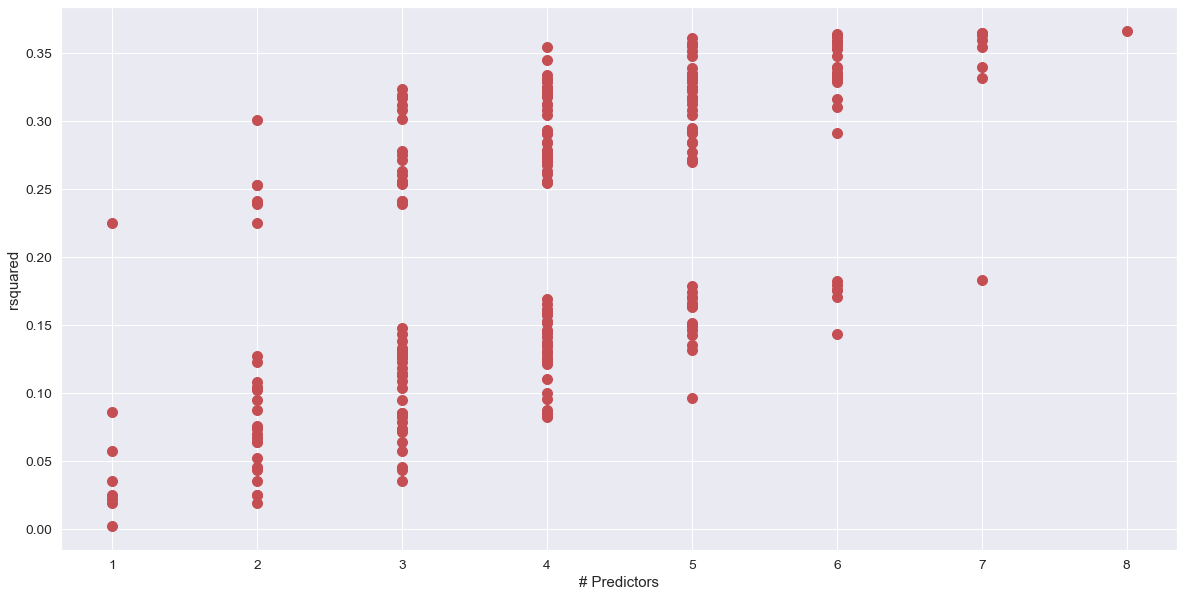

In [55]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    #plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plot_array = []
    for i in range(1, models_best.shape[0]+1):
        #print(i)
        models_made = models_best.loc[models_best['num_elements'] == i]['model'][i]
        for k in range(models_made.shape[0]):
            plot_array.append([i, models_made['model'], models_made['llr_pvalue'][k], models_made['vars'][k]])
        
    data = pd.DataFrame(plot_array, columns = ['num_elements', 'model', 'rsquared', 'vars'])
    plt.plot(data['num_elements'], data['rsquared'], 'ro')
    plt.xlabel('# Predictors')
    plt.ylabel('rsquared')
    #plt.yscale("log")

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    '''
    rsquared_adj = models_best.apply(lambda row: row[1].llr_pvalue, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
    '''
    return data

all_models = best_sub_plots()

This plot, which shows all possible combinations of the parameters found to work on their own, uses the psuedo r2 value provided in logistic regression as a substitute for the r2 value used in linear cases. This shows that the model tends to improve as more variables are included, but not for all variables - the dividing line of 0.2 appears to break the variables into two sections

In [56]:
def new_col(var, dfr):
    return dfr['vars'].apply(lambda x: var in x)

for variable in list(X.columns):
    all_models[variable] = new_col(variable, all_models)
    

In [57]:
all_models[all_models.rsquared > 0.2][list(X.columns)].sum()

Pclass         63
Sex           120
Age            61
SibSp          56
Parch          61
Fare           59
Embarked       60
age_binned     62
dtype: int64

This shows that every time the model included sex as a predictor, the r2 was above 0.2, while very time Sex was not included the r2 value fell below 0.2. This shows the dramatic impact of this variable, and it is expected to bear out during further analysis. No other factor seemed to compare, as all other had roughly half above and below this line. 

In [58]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = train_with_age[predictors].select_dtypes(include=numerics)

X_vif = newdf.columns

In [59]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_vif = add_constant(train_with_age[X_vif])
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns

for i in range(len(X_vif.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X_vif.values, i)

print(vif_data)

  feature       VIF
0   const  5.950504
1     Age  1.011726
2    Fare  1.011726


As a last step, it can be seen here that the only two numerical variables do not have correlation issues

## Training Models - Emily & Hiba

In [61]:
final_train = train_with_age.drop(columns = ['PassengerId', 'Name', 'Ticket'])

In [63]:
logit_model1 = sm.logit(formula = 'Survived~ Pclass + Sex + Age + SibSp + Parch + Fare + Embarked + age_binned', data = final_train).fit()

         Current function value: 0.421673
         Iterations: 35


C:\Users\eleib\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [64]:
logit_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  889
Model:                          Logit   Df Residuals:                      862
Method:                           MLE   Df Model:                           26
Date:                Thu, 02 Mar 2023   Pseudo R-squ.:                  0.3661
Time:                        19:37:01   Log-Likelihood:                -374.87
converged:                      False   LL-Null:                       -591.41
Covariance Type:            nonrobust   LLR p-value:                 2.127e-75
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  5.1740      0.682      7.587      0.000       3.837       6.511
Pclass[T.2]                                               -1.0655      0.322     -3.313      0.001      -1.696      -0.435
Pclass[T.3]                                               -2.0496      0.332     -6.181      0.000      -2.699      -1.400
Sex[T.male]                                               -2.7495      0.210    -13.115      0.000      -3.160      -2.339
SibSp[T.1]                                                 0.0349      0.228      0.153      0.879      -0.412       0.482
SibSp[T.2]                                                -0.4261      0.569     -0.748      0.454      -1.542       0.690
SibSp[T.3]                                                -2.6403      0.734     -3.598      0.000      -4.079      -1.202
SibSp[T.4]                                                -2.4471      0.835     -2.930      0.003      -4.084      -0.810
SibSp[T.5]                                                -9.5063     64.216     -0.148      0.882    -135.368     116.355
SibSp[T.8]                                               -22.2597   1.75e+04     -0.001      0.999   -3.44e+04    3.43e+04
Parch[T.1]                                                -0.0272      0.317     -0.086      0.932      -0.648       0.594
Parch[T.2]                                                -0.3304      0.404     -0.817      0.414      -1.123       0.462
Parch[T.3]                                                 0.3552      1.066      0.333      0.739      -1.735       2.445
Parch[T.4]                                               -28.5855   9.63e+05  -2.97e-05      1.000   -1.89e+06    1.89e+06
Parch[T.5]                                                -1.6022      1.192     -1.345      0.179      -3.938       0.733
Parch[T.6]                                               -10.8952    227.193     -0.048      0.962    -456.185     434.395
Embarked[T.Q]                                              0.0714      0.392      0.182      0.855      -0.697       0.840
Embarked[T.S]                                             -0.3302      0.250     -1.320      0.187      -0.821       0.160
age_binned[T.Interval(10.368, 20.315, closed='right')]    -1.5421      0.664     -2.322      0.020      -2.844      -0.241
age_binned[T.Interval(20.315, 30.263, closed='right')]    -1.4900      0.872     -1.708      0.088      -3.200       0.220
age_binned[T.Interval(30.263, 40.21, closed='right')]     -0.9813      1.144     -0.858      0.391      -3.223       1.261
age_binned[T.Interval(40.21, 50.158, closed='right')]     -1.2909      1.465     -0.881      0.378      -4.162       1.580
age_binned[T.Interval(50.158, 60.105, closed='right')]    -1.1411      1.825     -0.625      0.532      -4.717       2.435
age_binned[T.Interval(60.105, 70.052, close

In [65]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

In [68]:
# cut bc don't use test anymore
# final_test = test.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin'])

In [69]:
# #Binning Age
# binned_age = pd.cut(final_test['Age'],8,retbins=True)
# final_test['age_binned'] = binned_age[0]
# #age_data = train_with_age.groupby('age_binned')['Survived'].agg([('survival_percent','mean'),('nobs','count')]).reset_index(drop=False)
# #age_data

In [70]:
# final_test.head()
# final_train['Pclass'] = final_train['Pclass'].astype(float)
# final_train['SibSp'] = final_train['SibSp'].astype(float)
# #final_train['Parch'] = final_train['Parch'].astype(float)
# #final_train.head()

In [191]:
#confusion_matrix_data(final_test, final_train.Survived, logit_model1)

In [71]:
final_train = train_with_age.drop(columns = ['PassengerId', 'Name', 'Ticket'])

In [72]:
final_train = pd.get_dummies(final_train, columns = ['Sex'], drop_first = True)

In [73]:
final_train.rename(columns={"Sex_male": "Sex"}, inplace = True)

In [74]:
final_train['Embarked'] = final_train['Embarked'].apply(lambda x: 1 if x == 'S' else 
                                                               2 if x == 'C' else 
                                                               0)

In [75]:
X_train = final_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

In [76]:
y = final_train.Survived
X = final_train.drop('Survived', axis = 1)

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 45)

In [78]:
X_train = X_train.drop('age_binned', axis = 1)

In [79]:
X_test = X_test.drop('age_binned', axis = 1)

In [80]:
from sklearn.linear_model import LogisticRegression
sklearn_model = LogisticRegression()
sklearn_model.fit(X_train, y_train)

LogisticRegression()

In [81]:
y_pred_test = sklearn_model.predict(X_test)
print('Accuracy of logistic regression on test set : {:.4f}'.format(sklearn_model.score(X_test, y_test)))

Accuracy of logistic regression on test set : 0.7910


#### ACTUAL Feature Selection 

In [83]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
 

In [85]:
def fit_logistic_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LogisticRegression()
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

In [86]:
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook

k = 11
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X_train.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X_train.columns,k):
        tmp_result = fit_logistic_reg(X_train[list(combo)],y_train)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

C:\Users\eleib\AppData\Local\Temp\ipykernel_19992\3908137826.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X_train.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\eleib\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [87]:
df

,numb_features,RSS,R_squared,features
0,1,247.0,0.672848,"(Pclass,)"
1,1,292.0,0.613245,"(Age,)"
2,1,292.0,0.613245,"(SibSp,)"
3,1,296.0,0.607947,"(Parch,)"
4,1,258.0,0.658278,"(Fare,)"
...,...,...,...,...
122,6,147.0,0.805298,"(Pclass, Age, SibSp, Fare, Embarked, Sex)"
123,6,150.0,0.801325,"(Pclass, Age, Parch, Fare, Embarked, Sex)"
124,6,151.0,0.800000,"(Pclass, SibSp, Parch, Fare, Embarked, Sex)"
125,6,155.0,0.794702,"(Age, SibSp, Parch, Fare, Embarked, Sex)"


In [88]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
display(df_min.head(10))
display(df_max.head(10))

,numb_features,RSS,R_squared,features
6,1,158.0,0.790728,"(Sex,)"
21,2,154.0,0.796026,"(SibSp, Sex)"
32,3,149.0,0.802649,"(Pclass, Age, Sex)"
36,3,149.0,0.802649,"(Pclass, SibSp, Sex)"
75,4,148.0,0.803974,"(Pclass, SibSp, Parch, Sex)"
100,5,147.0,0.805298,"(Pclass, Age, SibSp, Parch, Sex)"
121,6,145.0,0.807947,"(Pclass, Age, SibSp, Parch, Embarked, Sex)"
126,7,146.0,0.806623,"(Pclass, Age, SibSp, Parch, Fare, Embarked, Sex)"


,numb_features,RSS,R_squared,features
6,1,158.0,0.790728,"(Sex,)"
21,2,154.0,0.796026,"(SibSp, Sex)"
32,3,149.0,0.802649,"(Pclass, Age, Sex)"
36,3,149.0,0.802649,"(Pclass, SibSp, Sex)"
75,4,148.0,0.803974,"(Pclass, SibSp, Parch, Sex)"
100,5,147.0,0.805298,"(Pclass, Age, SibSp, Parch, Sex)"
121,6,145.0,0.807947,"(Pclass, Age, SibSp, Parch, Embarked, Sex)"
126,7,146.0,0.806623,"(Pclass, Age, SibSp, Parch, Fare, Embarked, Sex)"


In [89]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df.head()

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,247.0,0.672848,"(Pclass,)",158.0,0.790728
1,1,292.0,0.613245,"(Age,)",158.0,0.790728
2,1,292.0,0.613245,"(SibSp,)",158.0,0.790728
3,1,296.0,0.607947,"(Parch,)",158.0,0.790728
4,1,258.0,0.658278,"(Fare,)",158.0,0.790728


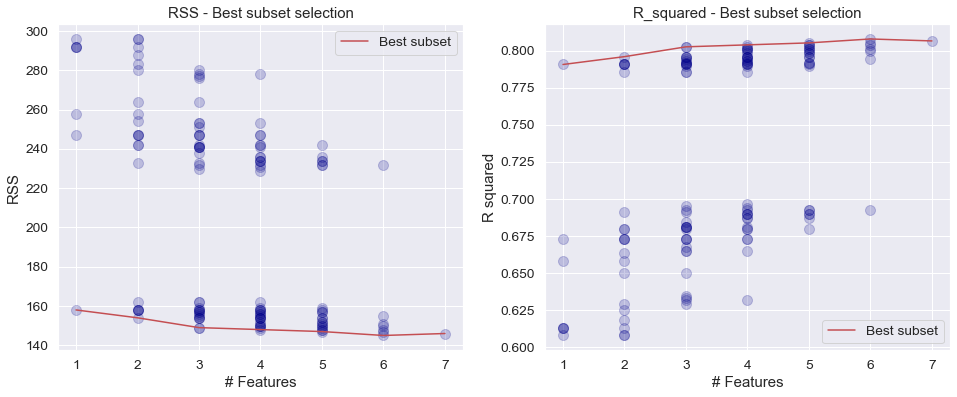

In [90]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

From the graph, the best number of features is either 6 or 7 which both minimize the RSS and maximize the R squared the most. 

In [91]:
#df[df["numb_features"] == 6] 
df[(df["numb_features"] == 6)].sort_values(by = ['R_squared'], ascending=False)

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
121,6,145.0,0.807947,"(Pclass, Age, SibSp, Parch, Embarked, Sex)",145.0,0.807947
122,6,147.0,0.805298,"(Pclass, Age, SibSp, Fare, Embarked, Sex)",145.0,0.807947
120,6,148.0,0.803974,"(Pclass, Age, SibSp, Parch, Fare, Sex)",145.0,0.807947
123,6,150.0,0.801325,"(Pclass, Age, Parch, Fare, Embarked, Sex)",145.0,0.807947
124,6,151.0,0.800000,"(Pclass, SibSp, Parch, Fare, Embarked, Sex)",145.0,0.807947
125,6,155.0,0.794702,"(Age, SibSp, Parch, Fare, Embarked, Sex)",145.0,0.807947
119,6,232.0,0.692715,"(Pclass, Age, SibSp, Parch, Fare, Embarked)",145.0,0.807947


In [92]:
df[(df["numb_features"] == 7)].sort_values(by = ['R_squared'], ascending=False)

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
126,7,146.0,0.806623,"(Pclass, Age, SibSp, Parch, Fare, Embarked, Sex)",146.0,0.806623


when the number of features is 6, the RSS is minimized and the R squared is maximized. This improves the fit of the model. The features that improve the model the best are (Pclass, Age, SibSp, Parch, Embarked, Sex). This means we are dropping the Fare cost.

### Selected variables: (Pclass, Age, SibSp, Parch, Fare, Embarked, Sex)	

In [93]:
X_train = X_train.drop('Fare', axis = 1)

In [94]:
X_test = X_test.drop('Fare', axis = 1)

In [95]:
sklearn_model = LogisticRegression()
sklearn_model.fit(X_train, y_train)

y_pred_test = sklearn_model.predict(X_test)
print('Accuracy of logistic regression on test set : {:.4f}'.format(sklearn_model.score(X_test, y_test)))

Accuracy of logistic regression on test set : 0.7985


## Performance Measurements Hiba & Emily

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,247.0,0.672848,"(Pclass,)",158.0,0.790728
1,1,292.0,0.613245,"(Age,)",158.0,0.790728
2,1,292.0,0.613245,"(SibSp,)",158.0,0.790728
3,1,296.0,0.607947,"(Parch,)",158.0,0.790728
4,1,258.0,0.658278,"(Fare,)",158.0,0.790728
